In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, mean_absolute_error
from sklearn.model_selection import train_test_split, KFold, cross_val_score

from sklearn.preprocessing import PolynomialFeatures


In [2]:
data_gba=pd.read_csv('../Data/data_todo_gba.csv',index_col=0)

<h1><font color='red'>Modelo GBA "Full Dummies"</font></h1>


En este modelo se incluirán las dummies por Localidades. Se dejarán de lado las correspondientes a zonas que han sido probadas en forma previa y resultaron no aportar a la performance del modelo

In [3]:
data_gba.head()

,tipo_propiedad,Provincia,Zona,Localidad,Barrio,place_name,cochera,gimnasio,piscina,SUM,...,balcon,patio,parrilla,floor,rooms,price_usd,sup_cub,sup_descub,sup_total,price_usd_per_m2
0,PH,Bs.As. G.B.A. Zona Norte,GBA,Vicente López,Munro,Munro,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,3.0,130000.0,78.00,28.00,106.0,1226.415094
1,apartment,Bs.As. G.B.A. Zona Norte,GBA,San Isidro,Martínez,Martínez,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,NaN,2.0,115000.0,36.00,3.00,39.0,2948.717949
2,house,Bs.As. G.B.A. Zona Norte,GBA,San Miguel,Bella Vista,Bella vista,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,4.0,250000.0,115.23,48.77,164.0,1524.390244
3,house,Bs.As. G.B.A. Zona Norte,GBA,Tigre,NaN,Tigre,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,4.0,570000.0,270.00,0.00,270.0,2111.111111
4,house,Bs.As. G.B.A. Zona Oeste,GBA,General Rodríguez,NaN,General rodríguez,0.0,0.0,1.0,1.0,...,0.0,1.0,1.0,0.0,4.0,290000.0,200.00,0.00,200.0,1450.000000


In [4]:
data_gba.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20424 entries, 0 to 20423
Data columns (total 21 columns):
tipo_propiedad      20424 non-null object
Provincia           20424 non-null object
Zona                20424 non-null object
Localidad           20276 non-null object
Barrio              14478 non-null object
place_name          20424 non-null object
cochera             20424 non-null float64
gimnasio            20424 non-null float64
piscina             20424 non-null float64
SUM                 20424 non-null float64
laundry             20424 non-null float64
balcon              20424 non-null float64
patio               20424 non-null float64
parrilla            20424 non-null float64
floor               15480 non-null float64
rooms               20424 non-null float64
price_usd           20424 non-null float64
sup_cub             18003 non-null float64
sup_descub          16314 non-null float64
sup_total           18735 non-null float64
price_usd_per_m2    20424 non-null fl

In [5]:
data_gba.columns

Index(['tipo_propiedad', 'Provincia', 'Zona', 'Localidad', 'Barrio',
       'place_name', 'cochera', 'gimnasio', 'piscina', 'SUM', 'laundry',
       'balcon', 'patio', 'parrilla', 'floor', 'rooms', 'price_usd', 'sup_cub',
       'sup_descub', 'sup_total', 'price_usd_per_m2'],
      dtype='object')

In [6]:
data_gba.loc[data_gba["sup_cub"]>data_gba["sup_total"], "Localidad"].value_counts()

Series([], Name: Localidad, dtype: int64)

In [7]:
sup_invertidas_drop = data_gba.loc[(data_gba['sup_cub'])>(data_gba['sup_total'])].index
print("Se va a dropear {} por error en superficies.".format(sup_invertidas_drop.size))
#data_gba.drop(index=sup_invertidas_drop,inplace=True)

Se va a dropear 0 por error en superficies.


In [8]:
data_gba.drop(index=sup_invertidas_drop,inplace=True)

Distribución de los Datos

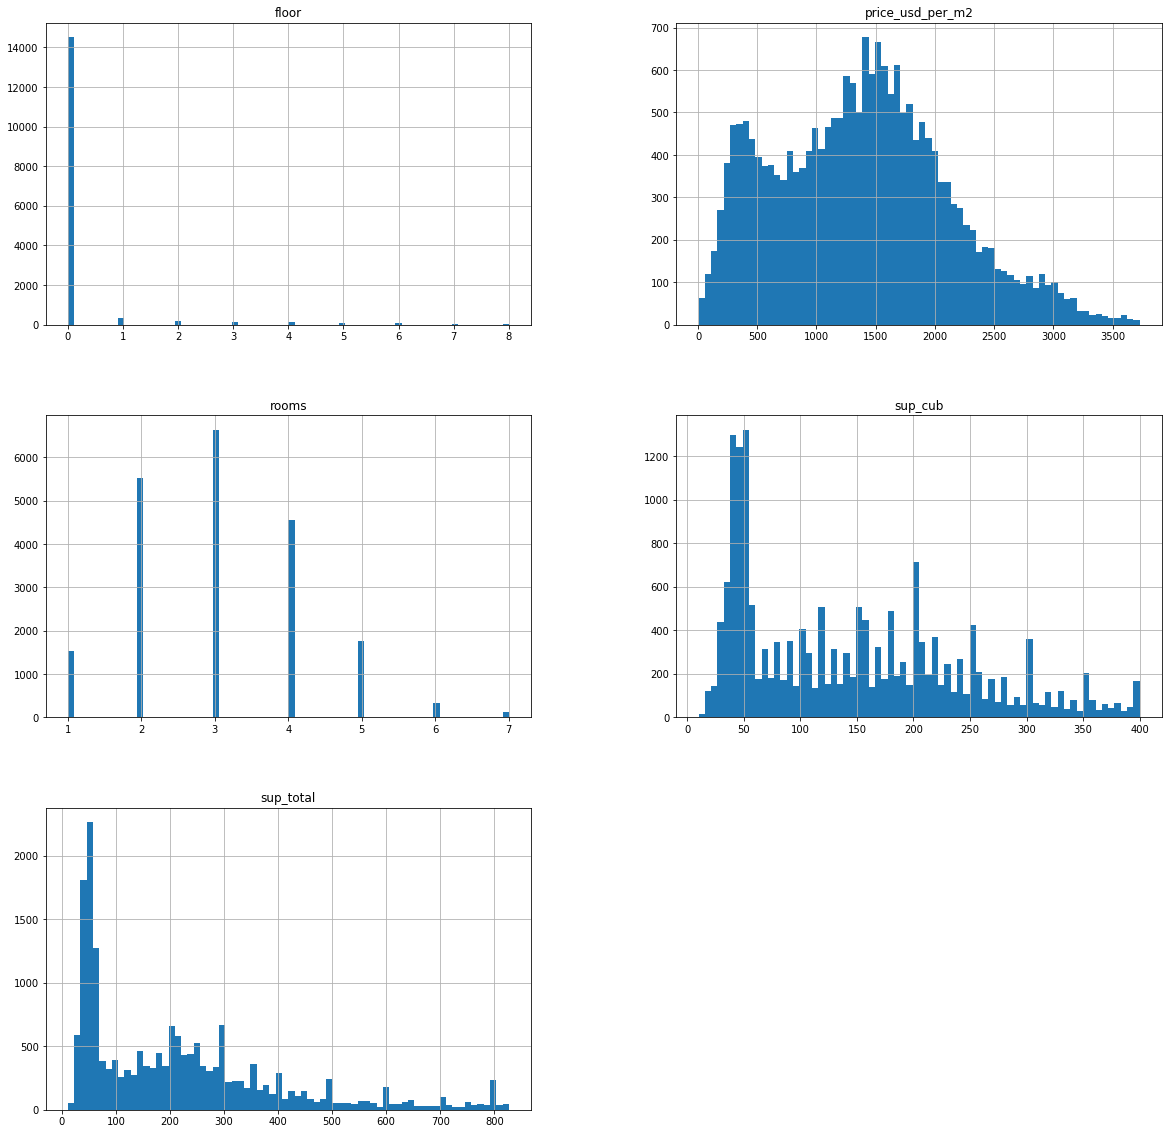

In [9]:
data_gba.loc[data_gba["tipo_propiedad"].notna(), ['sup_cub','tipo_propiedad','sup_total','price_usd_per_m2', 'rooms', 'floor']].hist(bins=70, figsize=(20,20))
plt.show()

ploteamos los atributos numéricos del modelo (exceptuando por lógica las variables dummies) . Queda claro que las variables tienen cada una su propia escala, por ello en un par de pasos mas adelante avanzaremos con la normalización de datos

In [10]:
data_gba.shape

(20424, 21)

In [11]:
data_gba.isna().sum()

tipo_propiedad         0
Provincia              0
Zona                   0
Localidad            148
Barrio              5946
place_name             0
cochera                0
gimnasio               0
piscina                0
SUM                    0
laundry                0
balcon                 0
patio                  0
parrilla               0
floor               4944
rooms                  0
price_usd              0
sup_cub             2421
sup_descub          4110
sup_total           1689
price_usd_per_m2       0
dtype: int64

Para GBA vamos a trabajar a nivel Localidad. Revisamos si se pueden recuperar los datos faltantes de localidad acudiendo al Barrio

In [12]:
data_gba.loc[(data_gba['Localidad'].isna())&(data_gba["Barrio"].notnull())]

,tipo_propiedad,Provincia,Zona,Localidad,Barrio,place_name,cochera,gimnasio,piscina,SUM,...,balcon,patio,parrilla,floor,rooms,price_usd,sup_cub,sup_descub,sup_total,price_usd_per_m2


In [13]:
cols_drop = ['Zona','place_name','price_usd','Barrio']
data_gba.drop(columns=cols_drop,inplace=True)

In [14]:
localidad_drop = data_gba.loc[data_gba['Localidad'].isna()].index
data_gba.drop(index=localidad_drop,inplace=True)
data_gba.isna().sum()

tipo_propiedad         0
Provincia              0
Localidad              0
cochera                0
gimnasio               0
piscina                0
SUM                    0
laundry                0
balcon                 0
patio                  0
parrilla               0
floor               4944
rooms                  0
sup_cub             2413
sup_descub          4089
sup_total           1676
price_usd_per_m2       0
dtype: int64

In [15]:
data_gba.notnull().sum()

tipo_propiedad      20276
Provincia           20276
Localidad           20276
cochera             20276
gimnasio            20276
piscina             20276
SUM                 20276
laundry             20276
balcon              20276
patio               20276
parrilla            20276
floor               15332
rooms               20276
sup_cub             17863
sup_descub          16187
sup_total           18600
price_usd_per_m2    20276
dtype: int64

# Creación de Variables Dummies

De las features Tipo de Propiedad y Localidad se generarán las variables dummies. Ya aclaramos que no utilizaremos las correspondientes a provincia (para identificar la zona) debido a que no aportaban al modelo

In [16]:
def add_dummy_vars(df,cat_vars):
    df_dummy = pd.get_dummies(df[cat_vars],drop_first=True,dtype=np.float64)
    df = pd.concat([df,df_dummy],axis=1)
    return df

In [17]:
cat_vars = ['tipo_propiedad',"Localidad"]
data_gba = add_dummy_vars(data_gba,cat_vars)
data_gba.head(5)

,tipo_propiedad,Provincia,Localidad,cochera,gimnasio,piscina,SUM,laundry,balcon,patio,...,Localidad_Pilar,Localidad_Presidente Perón,Localidad_Quilmes,Localidad_San Fernando,Localidad_San Isidro,Localidad_San Miguel,Localidad_San Vicente,Localidad_Tigre,Localidad_Tres de Febrero,Localidad_Vicente López
0,PH,Bs.As. G.B.A. Zona Norte,Vicente López,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,apartment,Bs.As. G.B.A. Zona Norte,San Isidro,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,house,Bs.As. G.B.A. Zona Norte,San Miguel,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,house,Bs.As. G.B.A. Zona Norte,Tigre,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,house,Bs.As. G.B.A. Zona Oeste,General Rodríguez,0.0,0.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
data_gba.columns

Index(['tipo_propiedad', 'Provincia', 'Localidad', 'cochera', 'gimnasio',
       'piscina', 'SUM', 'laundry', 'balcon', 'patio', 'parrilla', 'floor',
       'rooms', 'sup_cub', 'sup_descub', 'sup_total', 'price_usd_per_m2',
       'tipo_propiedad_apartment', 'tipo_propiedad_house',
       'tipo_propiedad_store', 'Localidad_Avellaneda', 'Localidad_Berazategui',
       'Localidad_Cañuelas', 'Localidad_Escobar',
       'Localidad_Esteban Echeverría', 'Localidad_Ezeiza',
       'Localidad_Florencio Varela', 'Localidad_General Rodríguez',
       'Localidad_General San Martín', 'Localidad_Hurlingham',
       'Localidad_Ituzaingó', 'Localidad_José C Paz', 'Localidad_La Matanza',
       'Localidad_La Plata', 'Localidad_Lanús', 'Localidad_Lomas de Zamora',
       'Localidad_Malvinas Argentinas', 'Localidad_Marcos Paz',
       'Localidad_Merlo', 'Localidad_Moreno', 'Localidad_Morón',
       'Localidad_Pilar', 'Localidad_Presidente Perón', 'Localidad_Quilmes',
       'Localidad_San Fernando', 'Lo

# División del dataset en Entrenamiento y Testeo

Vamos a utilizar un 25% del dataset para testeo.

In [155]:
data_gba_train, data_gba_test = train_test_split(data_gba,test_size=0.25,shuffle=True,random_state=10)#,stratify=data_gba['Localidad'])
data_gba_train = data_gba_train.copy()
data_gba_test = data_gba_test.copy() 
print("data GBA train shape: {}".format(data_gba_train.shape))
print("data GBA test shape: {}".format(data_gba_test.shape))

data GBA train shape: (15207, 52)
data GBA test shape: (5069, 52)


# Imputaciones en set de Entrenamiento

Se imputarán los valores faltantes del set de entrenamiento mediante alguna estrategia por tendencia central. Esos valores se guardarán para completar con el mismo criterio en el set de testeo (con los valores obtenidos del set de entrenamiento).

- Columna 'floor': se completa por la mediana por lugar.
- Columnas de Superficie Cubierta y Total: Se calcula un índice de construcción:

$Construction\:Index = \frac{Superficie\:Cubierta}{Superficie\:Total}$

Luego se calcula la media de este índice de construcción por barrio, y se imputa mediante esta media de construcción.

## Imputación del número de piso ('floor')

In [20]:
data_gba_train['floor'].isna().sum()

3713

In [21]:
floor_median_localidad = data_gba_train.loc[(data_gba_train['tipo_propiedad']=='apartment')|(data_gba_train['tipo_propiedad']=='store'),['floor','Localidad']].groupby('Localidad').agg(np.median)
floor_median_localidad['floor'].fillna(value=floor_median_localidad['floor'].mean(),inplace=True)
floor_median_localidad

,floor
Localidad,
Almirante Brown,0.0
Avellaneda,3.0
Escobar,1.0
Esteban Echeverría,0.0
Ezeiza,0.0
Florencio Varela,3.0
General Rodríguez,2.0
General San Martín,2.0
Ituzaingó,1.0


In [22]:
floor_median_prov = data_gba_train.loc[(data_gba_train['tipo_propiedad']=='apartment')|(data_gba_train['tipo_propiedad']=='store'),['floor','Provincia']].groupby('Provincia').agg(np.median)
floor_median_prov['floor'].fillna(value=floor_median_prov['floor'].mean(),inplace=True)
floor_median_prov

,floor
Provincia,
Bs.As. G.B.A. Zona Norte,2.0
Bs.As. G.B.A. Zona Oeste,3.0
Bs.As. G.B.A. Zona Sur,0.0


In [23]:
print("Datos faltantes de floor en train set: {}".format(data_gba_train['floor'].isna().sum()))
print("Datos faltantes de floor en test set: {}".format(data_gba_test['floor'].isna().sum()))

Datos faltantes de floor en train set: 3713
Datos faltantes de floor en test set: 1231


In [24]:
for localidad,floor_med in floor_median_localidad['floor'].to_dict().items():
    #imputo en el train set con los valores calculados
    data_gba_train.loc[((data_gba_train['tipo_propiedad']=='apartment')|(data_gba_train['tipo_propiedad']=='store')&(data_gba_train['floor'].isna())&(data_gba_train['Localidad']==localidad)),'floor']=floor_med
    #tambien imputo en el test set con los valores del train set.
    data_gba_test.loc[((data_gba_test['tipo_propiedad']=='apartment')|(data_gba_test['tipo_propiedad']=='store')&(data_gba_test['floor'].isna())&(data_gba_test['Localidad']==localidad)),'floor']=floor_med

In [25]:
print("Datos faltantes de floor en train set: {}".format(data_gba_train['floor'].isna().sum()))
print("Datos faltantes de floor en test set: {}".format(data_gba_test['floor'].isna().sum()))

Datos faltantes de floor en train set: 0
Datos faltantes de floor en test set: 0


Vamos a correr igualmente la imputación del índice por provincia para evitar que el código pinche con otra distribución en los sets de entenamiento / Testeo

In [26]:
for prov,floor_med in floor_median_prov['floor'].to_dict().items():
    #imputo en el train set con los valores calculados
    data_gba_train.loc[((data_gba_train['tipo_propiedad']=='apartment')|(data_gba_train['tipo_propiedad']=='store')&(data_gba_train['floor'].isna())&(data_gba_train['Provincia']==prov)),'floor']=floor_med
    #tambien imputo en el test set con los valores del train set.
    data_gba_test.loc[((data_gba_test['tipo_propiedad']=='apartment')|(data_gba_test['tipo_propiedad']=='store')&(data_gba_test['floor'].isna())&(data_gba_test['Provincia']==prov)),'floor']=floor_med

In [27]:
print("Datos faltantes de floor en train set: {}".format(data_gba_train['floor'].isna().sum()))
print("Datos faltantes de floor en test set: {}".format(data_gba_test['floor'].isna().sum()))

Datos faltantes de floor en train set: 0
Datos faltantes de floor en test set: 0


## Imputación de Superficies

Columna temporal de const_index.

In [28]:
data_gba_train['const_index']=data_gba_train['sup_cub']/data_gba_train['sup_total']
data_gba_train.head(5)

,tipo_propiedad,Provincia,Localidad,cochera,gimnasio,piscina,SUM,laundry,balcon,patio,...,Localidad_Presidente Perón,Localidad_Quilmes,Localidad_San Fernando,Localidad_San Isidro,Localidad_San Miguel,Localidad_San Vicente,Localidad_Tigre,Localidad_Tres de Febrero,Localidad_Vicente López,const_index
7386,house,Bs.As. G.B.A. Zona Oeste,Marcos Paz,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
17756,house,Bs.As. G.B.A. Zona Oeste,Morón,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.498615
11465,house,Bs.As. G.B.A. Zona Norte,Tigre,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.000000
6131,apartment,Bs.As. G.B.A. Zona Sur,Quilmes,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
19133,house,Bs.As. G.B.A. Zona Sur,Lomas de Zamora,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.459644


In [29]:
data_gba_train['const_index'].describe()

count    12124.000000
mean         0.795501
std          0.245342
min          0.025000
25%          0.681381
50%          0.888889
75%          1.000000
max          1.000000
Name: const_index, dtype: float64

In [30]:
data_gba_train.iloc[:,13:].describe()

,sup_cub,sup_descub,sup_total,price_usd_per_m2,tipo_propiedad_apartment,tipo_propiedad_house,tipo_propiedad_store,Localidad_Avellaneda,Localidad_Berazategui,Localidad_Cañuelas,...,Localidad_Presidente Perón,Localidad_Quilmes,Localidad_San Fernando,Localidad_San Isidro,Localidad_San Miguel,Localidad_San Vicente,Localidad_Tigre,Localidad_Tres de Febrero,Localidad_Vicente López,const_index
count,13398.000000,12124.000000,13933.000000,15207.000000,15207.000000,15207.000000,15207.000000,15207.000000,15207.000000,15207.000000,...,15207.000000,15207.000000,15207.000000,15207.000000,15207.000000,15207.000000,15207.000000,15207.000000,15207.000000,12124.000000
mean,144.396370,74.212369,218.877259,1387.861421,0.288683,0.659762,0.005063,0.016374,0.008417,0.000921,...,0.002367,0.011048,0.022950,0.052739,0.031696,0.002893,0.220228,0.031762,0.068850,0.795501
std,97.262087,137.096998,187.066557,737.800992,0.453165,0.473805,0.070980,0.126913,0.091361,0.030329,...,0.048599,0.104529,0.149749,0.223519,0.175195,0.053714,0.414414,0.175371,0.253207,0.245342
min,10.000000,0.000000,12.000000,4.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025000
25%,50.000000,0.000000,57.000000,804.347826,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.681381
50%,130.000000,9.000000,180.000000,1390.374332,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.888889
75%,210.000000,71.000000,300.000000,1869.158879,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,400.000000,791.000000,827.000000,3728.813559,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [31]:
# data_gba_test.loc[(data_gba_test['sup_descub']==float('inf')),['sup_cub','sup_descub','sup_total']]
# data_gba_train.loc[(data_gba_train['sup_descub']==float('inf')),['sup_cub','sup_descub','sup_total']]

In [32]:
const_median_localidad = data_gba_train[['const_index','Localidad']].groupby('Localidad').median()
const_median_localidad['const_index'].fillna(value=const_median_localidad['const_index'].median(),inplace=True)
const_median_localidad

,const_index
Localidad,
Almirante Brown,0.869495
Avellaneda,0.914286
Berazategui,0.891667
Cañuelas,0.775148
Escobar,0.882136
Esteban Echeverría,0.811266
Ezeiza,0.823529
Florencio Varela,0.852575
General Rodríguez,0.830121


Imputación del índice de construcción:

In [33]:
data_gba_train[['sup_cub','sup_total','sup_descub','const_index']].isna().sum()

sup_cub        1809
sup_total      1274
sup_descub     3083
const_index    3083
dtype: int64

In [34]:
data_gba_test[['sup_cub','sup_total','sup_descub']].isna().sum()

sup_cub        604
sup_total      402
sup_descub    1006
dtype: int64

In [35]:
for localidad,const_med in const_median_localidad['const_index'].to_dict().items():
    data_gba_train.loc[(data_gba_train['const_index'].isna())&(data_gba_train['Localidad']==localidad),'const_index']=const_med
    data_gba_test.loc[(data_gba_test['Localidad']==localidad),'const_index']=const_med

Completar los datos faltantes de Superficie Cubierta y Superficie Total con el índice de construcción calculado, en el set de entrenamiento.

In [36]:
data_gba_train['sup_cub'].fillna(data_gba_train['const_index']*data_gba_train['sup_total'],inplace=True)
data_gba_train['sup_total'].fillna(data_gba_train['sup_cub']/data_gba_train['const_index'],inplace=True)
data_gba_train['sup_descub'].fillna((data_gba_train['sup_total']-data_gba_train['sup_cub']),inplace=True)

In [37]:
data_gba_train[['sup_cub','sup_total','sup_descub','const_index']].isna().sum()

sup_cub        0
sup_total      0
sup_descub     0
const_index    0
dtype: int64

Completar los datos faltantes de Superficie Cubierta y Superficie Total con el índice de construcción calculado, en el set de testeo.

In [38]:
data_gba_test['sup_cub'].fillna(data_gba_test['const_index']*data_gba_test['sup_total'],inplace=True)
data_gba_test['sup_total'].fillna(data_gba_test['sup_cub']/data_gba_test['const_index'],inplace=True)
data_gba_test['sup_descub'].fillna((data_gba_test['sup_total']-data_gba_test['sup_cub']),inplace=True)


In [39]:
data_gba_test[['sup_cub','sup_total','sup_descub','const_index']].isna().sum()

sup_cub        0
sup_total      0
sup_descub     0
const_index    0
dtype: int64

Dependiendo de como hace el split, podrían quedar índices sin valor (en el caso de que una localidad haya quedado entera en el set de testeo) para evitar posibles errores, corremos el índice a nivel provincia

In [40]:
const_median_prov = data_gba_train[['const_index','Provincia']].groupby('Provincia').median()
const_median_prov['const_index'].fillna(value=const_median_prov['const_index'].median(),inplace=True)
const_median_prov

,const_index
Provincia,
Bs.As. G.B.A. Zona Norte,0.880000
Bs.As. G.B.A. Zona Oeste,0.833333
Bs.As. G.B.A. Zona Sur,0.925463


In [41]:
for prov,const_med in const_median_prov['const_index'].to_dict().items():
    data_gba_train.loc[(data_gba_train['const_index'].isna())&(data_gba_train['Provincia']==localidad),'const_index']=const_med
    data_gba_test.loc[(data_gba_test['Provincia']==localidad),'const_index']=const_med

Completar los datos faltantes de Superficie Cubierta y Superficie Total con el índice de construcción calculado, en el set de entrenamiento.

In [42]:
data_gba_train['sup_cub'].fillna(data_gba_train['const_index']*data_gba_train['sup_total'],inplace=True)
data_gba_train['sup_total'].fillna(data_gba_train['sup_cub']/data_gba_train['const_index'],inplace=True)
data_gba_train['sup_descub'].fillna((data_gba_train['sup_total']-data_gba_train['sup_cub']),inplace=True)

In [43]:
data_gba_test['sup_cub'].fillna(data_gba_test['const_index']*data_gba_test['sup_total'],inplace=True)
data_gba_test['sup_total'].fillna(data_gba_test['sup_cub']/data_gba_test['const_index'],inplace=True)
data_gba_test['sup_descub'].fillna((data_gba_test['sup_total']-data_gba_test['sup_cub']),inplace=True)

In [44]:
print("Para X_train en GBA queda: {}".format(data_gba_train.shape))
print("Para X_test en GBA queda: {}".format(data_gba_test.shape))

Para X_train en GBA queda: (15207, 52)
Para X_test en GBA queda: (5069, 52)


In [45]:
data_gba.columns


Index(['tipo_propiedad', 'Provincia', 'Localidad', 'cochera', 'gimnasio',
       'piscina', 'SUM', 'laundry', 'balcon', 'patio', 'parrilla', 'floor',
       'rooms', 'sup_cub', 'sup_descub', 'sup_total', 'price_usd_per_m2',
       'tipo_propiedad_apartment', 'tipo_propiedad_house',
       'tipo_propiedad_store', 'Localidad_Avellaneda', 'Localidad_Berazategui',
       'Localidad_Cañuelas', 'Localidad_Escobar',
       'Localidad_Esteban Echeverría', 'Localidad_Ezeiza',
       'Localidad_Florencio Varela', 'Localidad_General Rodríguez',
       'Localidad_General San Martín', 'Localidad_Hurlingham',
       'Localidad_Ituzaingó', 'Localidad_José C Paz', 'Localidad_La Matanza',
       'Localidad_La Plata', 'Localidad_Lanús', 'Localidad_Lomas de Zamora',
       'Localidad_Malvinas Argentinas', 'Localidad_Marcos Paz',
       'Localidad_Merlo', 'Localidad_Moreno', 'Localidad_Morón',
       'Localidad_Pilar', 'Localidad_Presidente Perón', 'Localidad_Quilmes',
       'Localidad_San Fernando', 'Lo

## Armando el Modelo de Regresión Lineal

## Ploteamos Variables Cuantitativas 

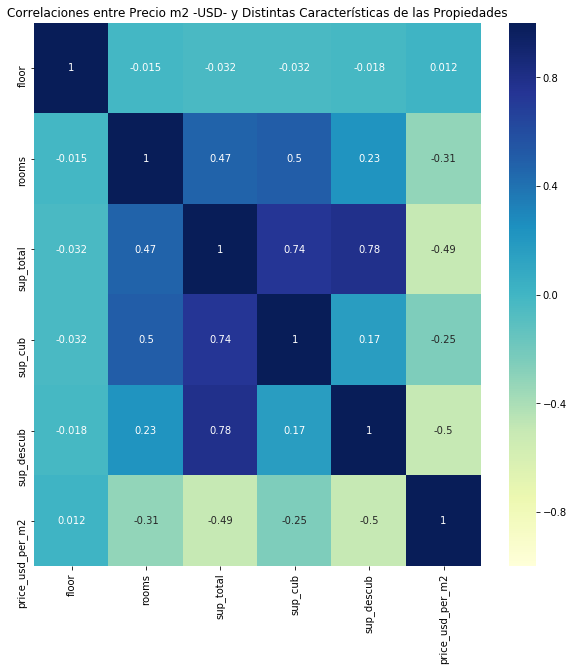

In [46]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Correlaciones entre Precio m2 -USD- y Distintas Características de las Propiedades', )

sns.heatmap(data_gba_train.loc[:,["floor",'rooms', 'sup_total','sup_cub','sup_descub',"price_usd_per_m2"]].corr(), vmin=-1, vmax=1, center=0, cmap="YlGnBu", annot=True);

plt.savefig('GBA v1 Correlaciones1.png')

De las correlaciones previas vemos que hay una relación negativa entre superficie y precio por m2. Esto se debe a que cuanto mas grandes son las propiedades, disminuye si valor por metro


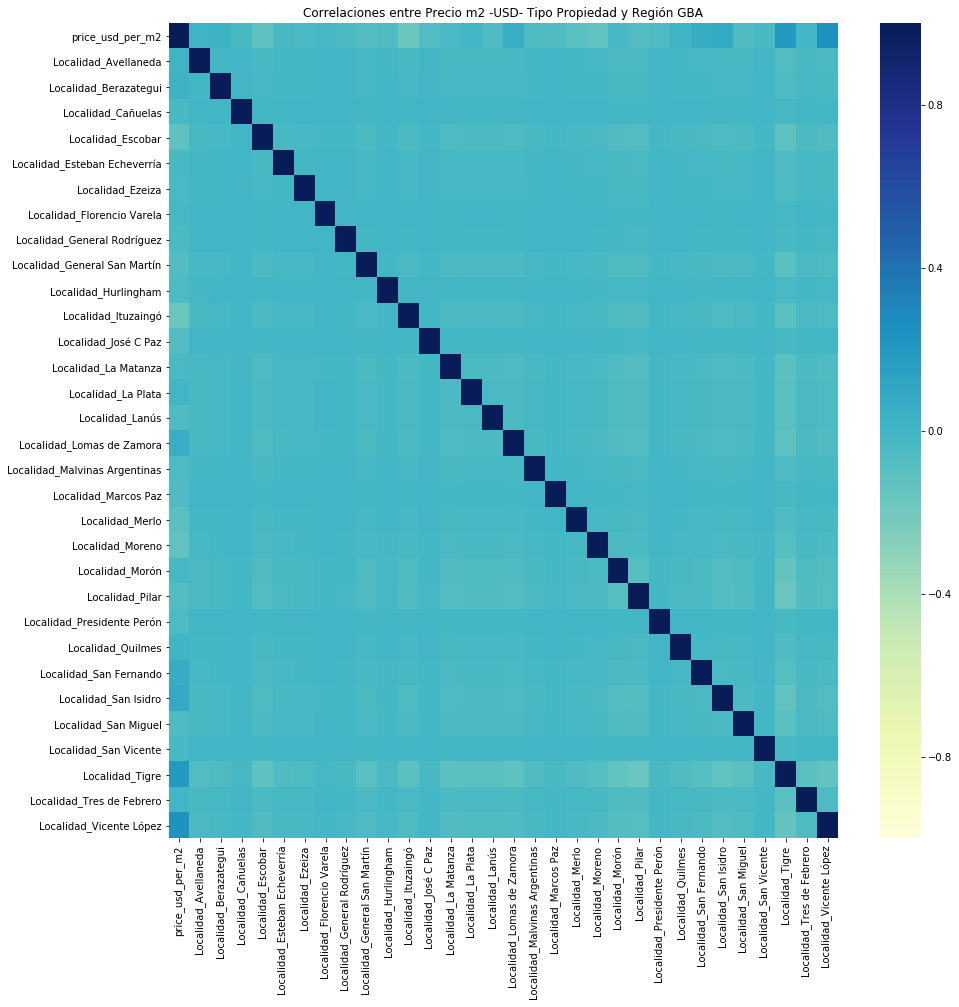

In [47]:
data_gba_localidades=data_gba.loc[:,['price_usd_per_m2','Localidad_Avellaneda',
       'Localidad_Berazategui', 'Localidad_Cañuelas', 'Localidad_Escobar',
       'Localidad_Esteban Echeverría', 'Localidad_Ezeiza',
       'Localidad_Florencio Varela', 'Localidad_General Rodríguez',
       'Localidad_General San Martín', 'Localidad_Hurlingham',
       'Localidad_Ituzaingó', 'Localidad_José C Paz', 'Localidad_La Matanza',
       'Localidad_La Plata', 'Localidad_Lanús', 'Localidad_Lomas de Zamora',
       'Localidad_Malvinas Argentinas', 'Localidad_Marcos Paz',
       'Localidad_Merlo', 'Localidad_Moreno', 'Localidad_Morón',
       'Localidad_Pilar', 'Localidad_Presidente Perón', 'Localidad_Quilmes',
       'Localidad_San Fernando', 'Localidad_San Isidro',
       'Localidad_San Miguel', 'Localidad_San Vicente', 'Localidad_Tigre',
       'Localidad_Tres de Febrero', 'Localidad_Vicente López']]

fig, ax = plt.subplots(figsize=(15,15))
ax.set_title('Correlaciones entre Precio m2 -USD- Tipo Propiedad y Región GBA', )
sns.heatmap(data_gba_localidades.corr(), vmin=-1, vmax=1, center=0, cmap="YlGnBu")#, annot=True);

plt.savefig('GBA v1 Correlaciones 2.png')


Las localidades mas correlacionadas con el precio m2 son las "esperables". Localidades mas caras: Vte Lopez, Tigre, San Fernando, San Isidro son las que evidencian una mayor correlación con el precio

## Definición de columnas a utilizar
###  Fit
Elegimos las columnas que son significativas para la predicción:<br>

Dummies relacionadas con Amenities: cochera, gimnasio, piscina, SUM, laundry, balcon, patio, parrilla
Dummies relacionadas con Características de la Propiedad: floor, rooms, sup_descub, sup_total
Dummies relacionadas con el tipo de propiedad: tipo_propiedad_apartment, tipo_propiedad_house, tipo_propiedad_store, PH es la excluida???
Dummies de Ubicación: Localidadades 

### Columna label
Esta columna la vamos a utilizar para indicar el valor de cada registro
*  price_usd_per_m2


## Sentido del Flujo de Trabajo

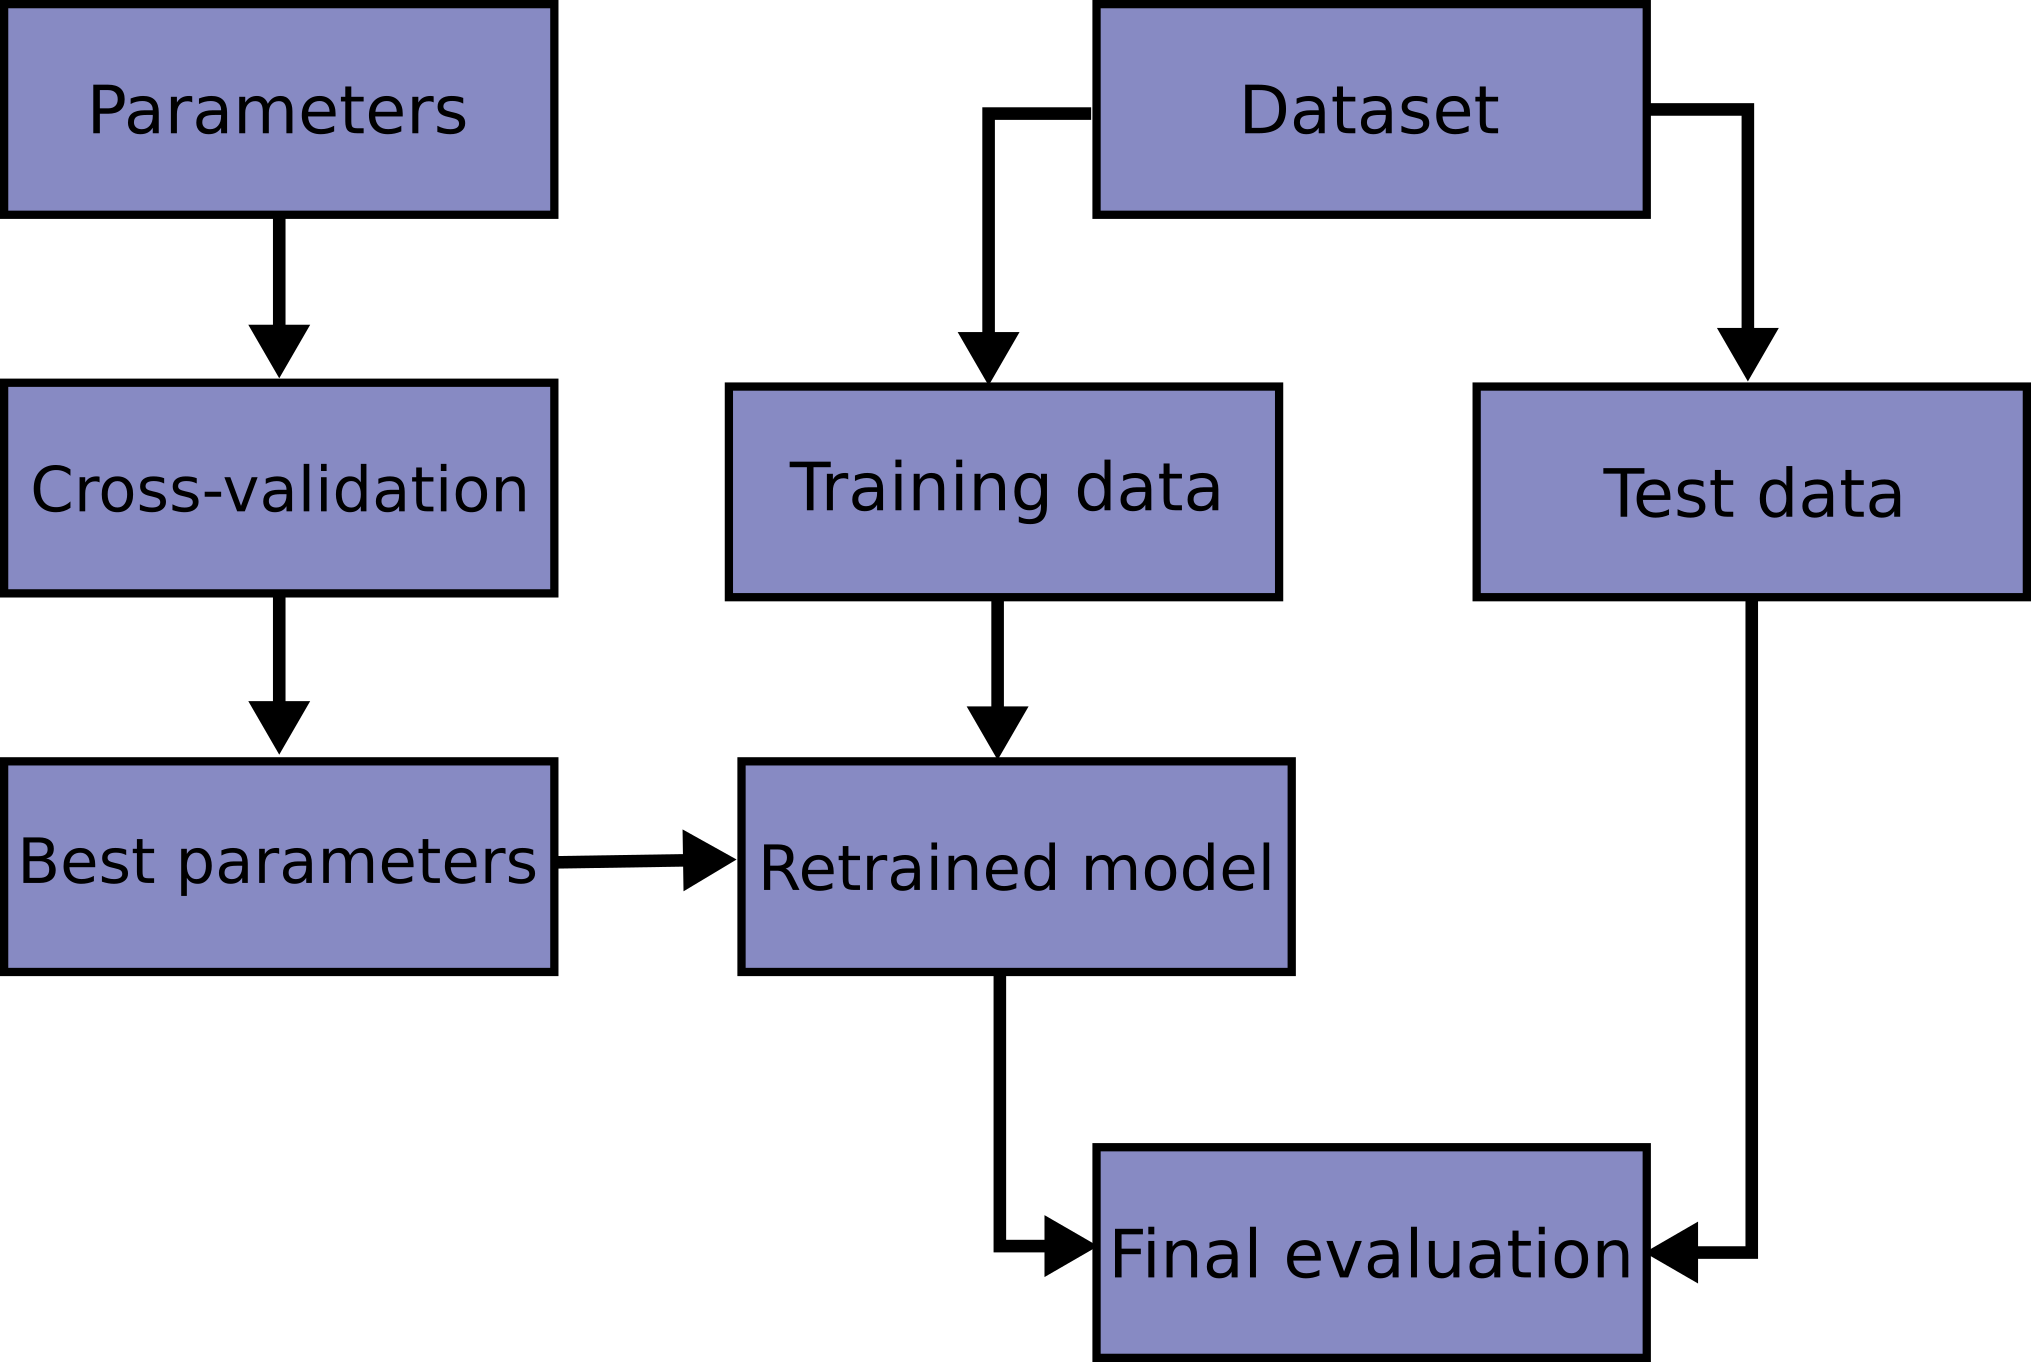

## Definición de Variables adicionales

In [48]:
#superficie por rooms, busca encontrar la valoración por ambientes de mayores dimensiones

data_gba['sup_por_room']=data_gba['sup_cub']/data_gba['rooms']
#data_gba['cub_desc']=data_gba['sup_cub']*data_gba['sup_descub']


#Creamos esas nuevas medidas en las particiones de entrenamiento y testeo. Como son variables que se calculan por fila
#no hay contaminación de sets
data_gba_train['sup_por_room']=data_gba_train['sup_cub']/data_gba_train['rooms']
#data_gba_train['cub_desc']=data_gba_train['sup_cub']*data_gba_train['sup_descub']

data_gba_test['sup_por_room']=data_gba_test['sup_cub']/data_gba_test['rooms']
#data_gba_test['cub_desc']=data_gba_test['sup_cub']*data_gba_test['sup_descub']



In [49]:
#data_gba['sup_descub'].value_counts()

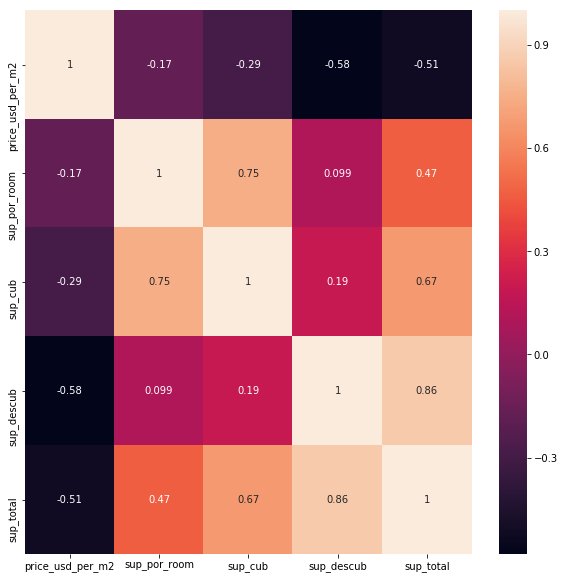

In [50]:
plt.figure(figsize=(10, 10))#,dpi=120)
#sns.set(font_scale=2) 
sns.heatmap(data_gba[['price_usd_per_m2','sup_por_room',"sup_cub","sup_descub",'sup_total']].corr(), annot=True)

plt.savefig('GBA v1 variables adicionales.png')

  Vamos a desestimar la "sup_total"
- Tenemos las otras dos variables LD 
- No participa de la creación de las nuevas features ya que nuestra nueva variable la calculamos a partir de la superficie cubierta

In [51]:
#data_gba_train.columns

In [52]:
#data_gba_test.columns

In [53]:
x_columns_drop = ['tipo_propiedad','Provincia','Localidad','const_index','price_usd_per_m2','sup_total']
y_column = 'price_usd_per_m2'

X_gba_train = data_gba_train.drop(columns=x_columns_drop)
y_gba_train = data_gba_train[y_column]
X_gba_test = data_gba_test.drop(columns=x_columns_drop)
y_gba_test = data_gba_test[y_column]

In [54]:
print("Shape X train:", X_gba_train.shape)
print("Shape y train:", y_gba_train.shape)

print("Type X train :", type(X_gba_train))
print("Type y train:", type(y_gba_train))

print("Shape X test:", X_gba_test.shape)
print("Shape y test:", y_gba_test.shape)

print("Type X test:", type(X_gba_test))
print("Type y test:", type(y_gba_test))

Shape X train: (15207, 47)
Shape y train: (15207,)
Type X train : <class 'pandas.core.frame.DataFrame'>
Type y train: <class 'pandas.core.series.Series'>
Shape X test: (5069, 47)
Shape y test: (5069,)
Type X test: <class 'pandas.core.frame.DataFrame'>
Type y test: <class 'pandas.core.series.Series'>


In [55]:
def print_metrics(y_gba_real,y_gba_pred):
    print('MAE:', round(mean_absolute_error(y_gba_real,y_gba_pred),6))
    print('MSE:', round(mean_squared_error(y_gba_real,y_gba_pred),6))
    print('RMSE:', round(np.sqrt(mean_squared_error(y_gba_real,y_gba_pred)),6))
    print('R2:', round(r2_score(y_gba_real,y_gba_pred),4))

## Primero Corremos el Modelo de Regresión Lineal

In [56]:
lm = LinearRegression()

model_linreg = lm.fit(X_gba_train, y_gba_train)

#Predicciones del modelo para el set de entrenamiento
y_gba_pred_tr_lm = model_linreg.predict(X_gba_train)
#Predicciones del modelo para el set de testeo
y_gba_pred_ts_lm = model_linreg.predict(X_gba_test)

#Métricas del modelo para el set de entrenamiento
print("Para el train set:")
print_metrics(y_gba_train,y_gba_pred_tr_lm)
print("------------------------------")

#Métricas del modelo para el set de testeo
print("Para el test set:")
print_metrics(y_gba_test,y_gba_pred_ts_lm)
print("------------------------------")

Para el train set:
MAE: 364.330148
MSE: 239700.158342
RMSE: 489.591828
R2: 0.5596
------------------------------
Para el test set:
MAE: 366.494852
MSE: 245909.832459
RMSE: 495.892965
R2: 0.5447
------------------------------


In [57]:
print(cross_val_score(model_linreg, X_gba_train, y_gba_train, cv=5))  

[0.53828815 0.56645183 0.55649896 0.54511289 0.57422399]


### Normalizamos los Datos Previo a Correr la Regularización

Al principio del trabajo vimos que las variables cuantitativas están expresadas cada una en su propia escala de valores. Daremos uniformidad estandarizándolas.

In [58]:
stdscalerX = StandardScaler()

x_columns_drop = ['tipo_propiedad','Provincia','Localidad','const_index','price_usd_per_m2','sup_total']
y_column = 'price_usd_per_m2'

X_gba_train = data_gba_train.drop(columns=x_columns_drop)
y_gba_train = data_gba_train[y_column]
X_gba_test = data_gba_test.drop(columns=x_columns_drop)
y_gba_test = data_gba_test[y_column]


Xs_gba_train = stdscalerX.fit_transform(X_gba_train)
ys_gba_train = y_gba_train

Xs_gba_test = stdscalerX.transform(X_gba_test)
ys_gba_test = y_gba_test

In [59]:
#lmreg = linear_model.LinearRegression()
model_linreg_std = lm.fit(Xs_gba_train,ys_gba_train)

#Predicciones del modelo para el set de entrenamiento
ys_gba_pred_tr_lm = model_linreg_std.predict(Xs_gba_train)
#Predicciones del modelo para el set de testeo
ys_gba_pred_ts_lm = model_linreg_std.predict(Xs_gba_test)

#Métricas del modelo para el set de entrenamiento
print("Para el train set:")
print_metrics(ys_gba_train,ys_gba_pred_tr_lm)
print("------------------------------")

#Métricas del modelo para el set de testeo
print("Para el test set:")
print_metrics(ys_gba_test,ys_gba_pred_ts_lm)
print("------------------------------")

Para el train set:
MAE: 364.330148
MSE: 239700.158342
RMSE: 489.591828
R2: 0.5596
------------------------------
Para el test set:
MAE: 366.494852
MSE: 245909.832459
RMSE: 495.892965
R2: 0.5447
------------------------------


No hay diferencias respecto al modelo lineal sin normalizar

## Corremos la Normalización Min-Max

In [60]:
from sklearn.preprocessing import MinMaxScaler

minmaxscalerX = MinMaxScaler()

x_columns_drop = ['tipo_propiedad','Provincia','Localidad','const_index','price_usd_per_m2','sup_total']
y_column = 'price_usd_per_m2'

X_gba_train = data_gba_train.drop(columns=x_columns_drop)
y_gba_train = data_gba_train[y_column]
X_gba_test = data_gba_test.drop(columns=x_columns_drop)
y_gba_test = data_gba_test[y_column]

Xn_gba_train = minmaxscalerX.fit_transform(X_gba_train)
yn_gba_train = y_gba_train

# Sobre el test set SOLO aplicamos transform !!!
Xn_gba_test = minmaxscalerX.transform(X_gba_test)
yn_gba_test = y_gba_test

In [61]:
#lmreg = linear_model.LinearRegression()
model_linreg_n = lm.fit(Xn_gba_train,yn_gba_train)

#Predicciones del modelo para el set de entrenamiento
yn_gba_pred_tr_lm = model_linreg_n.predict(Xn_gba_train)
#Predicciones del modelo para el set de testeo
yn_gba_pred_ts_lm = model_linreg_n.predict(Xn_gba_test)

#Métricas del modelo para el set de entrenamiento
print("Para el train set:")
print_metrics(yn_gba_train,yn_gba_pred_tr_lm)
print("------------------------------")

#Métricas del modelo para el set de testeo
print("Para el test set:")
print_metrics(yn_gba_test,yn_gba_pred_ts_lm)
print("------------------------------")

Para el train set:
MAE: 364.330148
MSE: 239700.158342
RMSE: 489.591828
R2: 0.5596
------------------------------
Para el test set:
MAE: 366.494852
MSE: 245909.832459
RMSE: 495.892965
R2: 0.5447
------------------------------


Corriendo la normalización por máximos y mínimos tampoco se registran diferencias respecto al modelo sin normalizar

## Función que crea polinomiales

In [62]:
from sklearn.preprocessing import PolynomialFeatures

def get_poly_X(poly_vars,y_var,df_train,df_test,degree=2):
    X_gba_train = df_train[poly_vars]
    y_gba_train = df_train[y_var]
    X_gba_test = df_test[poly_vars]
    y_gba_test = df_test[y_var]
    
    X_gba_train_pol = PolynomialFeatures(degree,include_bias=False,interaction_only=False).fit_transform(X_gba_train)
    X_gba_test_pol = PolynomialFeatures(degree,include_bias=False,interaction_only=False).fit_transform(X_gba_test)
    
    X_gba_train_pol = np.concatenate((X_gba_train_pol,df_train.drop(columns=poly_vars+y_var).values),axis=1)
    X_gba_test_pol = np.concatenate((X_gba_test_pol,df_test.drop(columns=poly_vars+y_var).values),axis=1)
    
    return X_gba_train_pol,X_gba_test_pol

## Creación de features polinomiales grado 2

In [63]:
data_gba_train.columns

Index(['tipo_propiedad', 'Provincia', 'Localidad', 'cochera', 'gimnasio',
       'piscina', 'SUM', 'laundry', 'balcon', 'patio', 'parrilla', 'floor',
       'rooms', 'sup_cub', 'sup_descub', 'sup_total', 'price_usd_per_m2',
       'tipo_propiedad_apartment', 'tipo_propiedad_house',
       'tipo_propiedad_store', 'Localidad_Avellaneda', 'Localidad_Berazategui',
       'Localidad_Cañuelas', 'Localidad_Escobar',
       'Localidad_Esteban Echeverría', 'Localidad_Ezeiza',
       'Localidad_Florencio Varela', 'Localidad_General Rodríguez',
       'Localidad_General San Martín', 'Localidad_Hurlingham',
       'Localidad_Ituzaingó', 'Localidad_José C Paz', 'Localidad_La Matanza',
       'Localidad_La Plata', 'Localidad_Lanús', 'Localidad_Lomas de Zamora',
       'Localidad_Malvinas Argentinas', 'Localidad_Marcos Paz',
       'Localidad_Merlo', 'Localidad_Moreno', 'Localidad_Morón',
       'Localidad_Pilar', 'Localidad_Presidente Perón', 'Localidad_Quilmes',
       'Localidad_San Fernando', 'Lo

In [64]:
poly_vars = ['floor','rooms','sup_cub','sup_descub','sup_por_room']
y_column = ['price_usd_per_m2']
poly_drop = ['tipo_propiedad', 'Provincia','Localidad','sup_total','const_index']
data_train2 = data_gba_train.drop(columns=poly_drop).copy()
data_test2 = data_gba_test.drop(columns=poly_drop).copy()

X_gba_train_pol2,X_gba_test_pol2 = get_poly_X(poly_vars = poly_vars, y_var = y_column, df_train = data_train2, df_test = data_test2,degree=2)
y_gba_train_pol2 = data_train2[y_column[0]]
y_gba_test_pol2 = data_test2[y_column[0]]


In [65]:
#lmreg = linear_model.LinearRegression()
model_linreg_pol = lm.fit(X_gba_train_pol2, y_gba_train_pol2)

#Predicciones del modelo para el set de entrenamiento
y_gba_pred_tr_lm_pol2 = model_linreg_pol.predict(X_gba_train_pol2)
#Predicciones del modelo para el set de testeo
y_gba_pred_ts_lm_pol2 = model_linreg_pol.predict(X_gba_test_pol2)

#Métricas del modelo para el set de entrenamiento
print("Para el train set:")
print_metrics(y_gba_train_pol2,y_gba_pred_tr_lm_pol2)
print("------------------------------")

#Métricas del modelo para el set de testeo
print("Para el test set:")
print_metrics(y_gba_test_pol2,y_gba_pred_ts_lm_pol2)
print("------------------------------")

Para el train set:
MAE: 351.271857
MSE: 228596.501865
RMSE: 478.117665
R2: 0.58
------------------------------
Para el test set:
MAE: 353.728678
MSE: 232386.67635
RMSE: 482.065013
R2: 0.5698
------------------------------


Incluir features polinómicas a nuestro modelo de regresión lineal aumenta el R2, esto es, el modelo ahora explica mayor parte de la variabilidad de los datos. 
Está disminuyendo el sesgo de los datos respecto al modelo de regresión. En el mismo sentido disminutó el RMSE (error cuadrático medio raiz, la función de pérdida que estamos buscando minimizar)

## Creación de features polinomiales grado 3

In [66]:
data_gba_train.columns

Index(['tipo_propiedad', 'Provincia', 'Localidad', 'cochera', 'gimnasio',
       'piscina', 'SUM', 'laundry', 'balcon', 'patio', 'parrilla', 'floor',
       'rooms', 'sup_cub', 'sup_descub', 'sup_total', 'price_usd_per_m2',
       'tipo_propiedad_apartment', 'tipo_propiedad_house',
       'tipo_propiedad_store', 'Localidad_Avellaneda', 'Localidad_Berazategui',
       'Localidad_Cañuelas', 'Localidad_Escobar',
       'Localidad_Esteban Echeverría', 'Localidad_Ezeiza',
       'Localidad_Florencio Varela', 'Localidad_General Rodríguez',
       'Localidad_General San Martín', 'Localidad_Hurlingham',
       'Localidad_Ituzaingó', 'Localidad_José C Paz', 'Localidad_La Matanza',
       'Localidad_La Plata', 'Localidad_Lanús', 'Localidad_Lomas de Zamora',
       'Localidad_Malvinas Argentinas', 'Localidad_Marcos Paz',
       'Localidad_Merlo', 'Localidad_Moreno', 'Localidad_Morón',
       'Localidad_Pilar', 'Localidad_Presidente Perón', 'Localidad_Quilmes',
       'Localidad_San Fernando', 'Lo

In [67]:
data_gba_test.columns

Index(['tipo_propiedad', 'Provincia', 'Localidad', 'cochera', 'gimnasio',
       'piscina', 'SUM', 'laundry', 'balcon', 'patio', 'parrilla', 'floor',
       'rooms', 'sup_cub', 'sup_descub', 'sup_total', 'price_usd_per_m2',
       'tipo_propiedad_apartment', 'tipo_propiedad_house',
       'tipo_propiedad_store', 'Localidad_Avellaneda', 'Localidad_Berazategui',
       'Localidad_Cañuelas', 'Localidad_Escobar',
       'Localidad_Esteban Echeverría', 'Localidad_Ezeiza',
       'Localidad_Florencio Varela', 'Localidad_General Rodríguez',
       'Localidad_General San Martín', 'Localidad_Hurlingham',
       'Localidad_Ituzaingó', 'Localidad_José C Paz', 'Localidad_La Matanza',
       'Localidad_La Plata', 'Localidad_Lanús', 'Localidad_Lomas de Zamora',
       'Localidad_Malvinas Argentinas', 'Localidad_Marcos Paz',
       'Localidad_Merlo', 'Localidad_Moreno', 'Localidad_Morón',
       'Localidad_Pilar', 'Localidad_Presidente Perón', 'Localidad_Quilmes',
       'Localidad_San Fernando', 'Lo

In [68]:
poly_vars = ['floor','rooms','sup_cub','sup_descub','sup_por_room']
y_column = ['price_usd_per_m2']
poly_drop = ['tipo_propiedad', 'Provincia','Localidad','sup_total','const_index']
data_train3 = data_gba_train.drop(columns=poly_drop).copy()
data_test3 = data_gba_test.drop(columns=poly_drop).copy()

X_gba_train_pol3,X_gba_test_pol3 = get_poly_X(poly_vars = poly_vars, y_var = y_column, df_train = data_train3, df_test = data_test3,degree=3)
y_gba_train_pol3 = data_train3[y_column[0]]
y_gba_test_pol3 = data_test3[y_column[0]]

In [69]:
#lmreg = linear_model.LinearRegression()
model_linreg_pol = lm.fit(X_gba_train_pol3,y_gba_train)

#Predicciones del modelo para el set de entrenamiento
y_gba_pred_tr_lm_pol3 = model_linreg_pol.predict(X_gba_train_pol3)
#Predicciones del modelo para el set de testeo
y_gba_pred_ts_lm_pol3 = model_linreg_pol.predict(X_gba_test_pol3)

#Métricas del modelo para el set de entrenamiento
print("Para el train set:")
print_metrics(y_gba_train_pol3, y_gba_pred_tr_lm_pol3)
print("------------------------------")

#Métricas del modelo para el set de testeo
print("Para el test set:")
print_metrics(y_gba_test_pol3,y_gba_pred_ts_lm_pol3)
print("------------------------------")

Para el train set:
MAE: 346.210513
MSE: 222677.719317
RMSE: 471.887401
R2: 0.5909
------------------------------
Para el test set:
MAE: 355.07375
MSE: 426317.597509
RMSE: 652.93001
R2: 0.2107
------------------------------


Al incluir en el modelo Features polinómicas de 3er grado, en el set de entrenamiento vemos que aumentó el R2, esto por ahora es positivo, pero , al validar el modelo con el set de testeo la caida abrupta del indicador evidencia que el aumento en la variabilidad de los datos se produjo a causa de un Overfiting en el set de entrenamiento. 

# Comparación de LR, Lasso y Ridge con features originales

## Ahora vamos a Tunear los Hiperparámetros

* regresión lineal sin regularizar(`LinearRegression()`)
* regresión lineal regularizada Ridge (`Ridge()`, `RidgeCV()`)
* regresión lineal regularizada LASSO (`Lasso()`, `LassoCV()`)


In [70]:
#Generamos un grid de "alphas" para probar e instanciamos un particionador del Training Set 
#Estos alphas se encuentran ajustados a las distintas pruebas de hiperparámetros (inicialmente el alpha óptimo coincidia 
#con el límite inferior 0.01 por ello se hizo un ajuste del mismo para darle mas libertad al ajuste del hiperparámetro)
#en K partes para realizar la validación cruzada

al_gba_ridge = np.linspace(100, 200, 100)
al_gba_lasso = np.linspace(0.1, 1, 100)

kf_gba = KFold(n_splits=5, shuffle=True, random_state=15)

# Instanciamos los modelos, como los datos ya están estandarizados. Corremos Ridge y Lasso y Elastic Net para Regularizar

lm_gba = LinearRegression(fit_intercept=True)

lm_gba_ridge_cv= RidgeCV(alphas=al_gba_ridge, cv=kf_gba, normalize=False)
lm_gba_lasso_cv = LassoCV(alphas=al_gba_lasso, cv=kf_gba, normalize=False,max_iter=1000)


In [71]:
stdscalerX = StandardScaler()

x_columns_drop = ['tipo_propiedad','Provincia','Localidad','const_index','price_usd_per_m2','sup_total']
y_column = 'price_usd_per_m2'

X_gba_train = data_gba_train.drop(columns=x_columns_drop)
y_gba_train = data_gba_train[y_column]
X_gba_test = data_gba_test.drop(columns=x_columns_drop)
y_gba_test = data_gba_test[y_column]

Xs_gba_train = stdscalerX.fit_transform(X_gba_train)
ys_gba_train = y_gba_train

Xs_gba_test = stdscalerX.transform(X_gba_test)
ys_gba_test = y_gba_test

In [72]:
model_linreg = lm_gba.fit(Xs_gba_train, np.ravel(ys_gba_train))

In [73]:
model_lin_ridge = lm_gba_ridge_cv.fit(Xs_gba_train, np.ravel(ys_gba_train))

In [74]:
model_lin_lasso = lm_gba_lasso_cv.fit(Xs_gba_train, np.ravel(ys_gba_train))

### Vemos cuales son los ALPHA calculados

In [76]:
print('Alpha Ridge para modelo GBA:',model_lin_ridge.alpha_,'\n'
      'Alpha LASSO para modelo GBA:',model_lin_lasso.alpha_,'\n')


Alpha Ridge para modelo GBA: 116.16161616161617 
Alpha LASSO para modelo GBA: 0.2727272727272727 



en esta instancia ya se hicieron los ajustes y quedan expresados sólo los hiperparámetros optimizados 

## Ya seteamos los hiperparámetros, ahora vamos a correr el modelo en todo el training set

In [77]:
# Calculamos el R2

print("Score Train Lineal: %.4f\n" % model_linreg.score(Xs_gba_train, np.ravel(ys_gba_train)),
    "Score Train Ridge : %.4f\n" % model_lin_ridge.score(Xs_gba_train, np.ravel(ys_gba_train)),
    "Score Train Lasso : %.4f\n" %  model_lin_lasso.score(Xs_gba_train, np.ravel(ys_gba_train)))
      #"Score Train ElasticNet : %.4f\n" %  model_lin_ElasticNet.score(Xs_gba_train, ys_gba_train))
        
# Calculamos el RMSE

ys_gba_pred_tr_lm = model_linreg.predict(Xs_gba_train)
ys_gba_pred_tr_ridge = model_lin_ridge.predict(Xs_gba_train)
ys_gba_pred_tr_lasso = model_lin_lasso.predict(Xs_gba_train)
#ys_pred_tr_elasticNet = model_lin_ElasticNet.predict(Xs_gba_train)

rmse = lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred))

print("Train RMSE lineal   : %.4f \n" % rmse(ys_gba_train, np.ravel(ys_gba_pred_tr_lm)),
    "Train RMSE Ridge    : %.4f \n" % rmse(ys_gba_train, np.ravel(ys_gba_pred_tr_ridge)),
    "Train RMSE Lasso    : %.4f \n" % rmse(ys_gba_train, np.ravel(ys_gba_pred_tr_lasso)))
      #"Train RMSE ElasticNet    : %.4f \n" % rmse(ys_gba_train,ys_gba_pred_tr_elasticNet))




Score Train Lineal: 0.5596
 Score Train Ridge : 0.5596
 Score Train Lasso : 0.5596

Train RMSE lineal   : 489.5918 
 Train RMSE Ridge    : 489.6120 
 Train RMSE Lasso    : 489.6065 



In [78]:
# Hacemos las predicciones sobre la matriz de predictores del Test Set

ys_gba_pred_lm = model_linreg.predict(Xs_gba_test)
ys_gba_pred_ridge = model_lin_ridge.predict(Xs_gba_test)
ys_gba_pred_lasso = model_lin_lasso.predict(Xs_gba_test)


print(" Score Test Lineal: %.4f\n" % model_linreg.score(Xs_gba_test, ys_gba_test),
      "Score Test Ridge : %.4f\n" % model_lin_ridge.score(Xs_gba_test, ys_gba_test),
      "Score Test Lasso : %.4f\n" %  model_lin_lasso.score(Xs_gba_test, ys_gba_test))

# Testeo final del modelo sobre Test Set

print(" Test RMSE lineal= %.4f\n" % rmse(ys_gba_test, ys_gba_pred_lm),
      "Test RMSE Ridge = %.4f\n" %  rmse(ys_gba_test, ys_gba_pred_ridge),
      "Test RMSE Lasso = %.4f" %  rmse(ys_gba_test, ys_gba_pred_lasso))

 Score Test Lineal: 0.5447
 Score Test Ridge : 0.5449
 Score Test Lasso : 0.5448

 Test RMSE lineal= 495.8930
 Test RMSE Ridge = 495.8184
 Test RMSE Lasso = 495.8398


Vemos que no hay diferencias significativas al regularizar los datos

In [79]:
r2_train_lin_d1 = model_linreg.score(Xs_gba_train, ys_gba_train)
r2_test_lin_d1 = model_linreg.score(Xs_gba_test, ys_gba_test)

r2_train_ridge_d1 = model_lin_ridge.score(Xs_gba_train, ys_gba_train)
r2_test_ridge_d1 = model_lin_ridge.score(Xs_gba_test, ys_gba_test)

r2_train_lasso_d1 = model_lin_lasso.score(Xs_gba_train, ys_gba_train)
r2_test_lasso_d1 = model_lin_lasso.score(Xs_gba_test, ys_gba_test)

## Cuáles son los Parámetros del Modelo??

In [80]:
np.set_printoptions(precision=2, suppress=True)
print("El intercepto y el vector de coeficientes del Modelo de Regresion Simple sin Regularizar son:")
(model_linreg.intercept_ , model_linreg.coef_)


El intercepto y el vector de coeficientes del Modelo de Regresion Simple sin Regularizar son:


(1387.861421205904,
 array([  12.72,   13.68,   57.41,    2.6 ,   30.7 ,   23.24,    6.51,
          11.75,   12.02,  -46.76,   29.88, -260.5 ,  238.13,  -60.6 ,
           3.15,  -32.67,   35.92,   -6.81,  -25.06,    9.98,   -3.61,
         -11.19,  -15.24,  -47.78,  -14.78,  -57.9 ,  -21.21,  -28.2 ,
         -31.76,  -52.02,    2.06,  -29.74,  -21.24,  -35.08,  -47.06,
         -46.94,  -28.02,  -13.38,   -6.36,   21.63,   76.04,  -56.37,
          -6.78,  120.11,  -47.11,  123.65,  -43.77]))

In [81]:
np.set_printoptions(precision=2, suppress=True)
print("El intercepto y el vector de coeficientes del Modelo de Regresion Simple Regularizado con Ridge son:")
(model_lin_ridge.intercept_ , model_lin_ridge.coef_)

El intercepto y el vector de coeficientes del Modelo de Regresion Simple Regularizado con Ridge son:


(1387.861421205904,
 array([  13.12,   14.03,   57.05,    3.15,   30.19,   24.02,    5.68,
          12.01,   11.26,  -45.52,   26.58, -258.57,  230.13,  -66.83,
           2.18,  -32.12,   35.69,   -6.8 ,  -24.92,    9.87,   -3.62,
         -11.06,  -15.08,  -47.65,  -14.7 ,  -57.6 ,  -21.16,  -27.96,
         -31.22,  -51.55,    2.55,  -29.39,  -21.15,  -34.89,  -46.7 ,
         -46.25,  -27.54,  -13.36,   -6.23,   21.68,   75.75,  -55.57,
          -6.79,  119.9 ,  -46.51,  122.98,  -40.98]))

In [82]:
np.set_printoptions(precision=2, suppress=True)
print("El intercepto y el vector de coeficientes del Modelo de Regresion Simple Regularizado con Lasso son:")
(model_lin_lasso.intercept_ , model_lin_lasso.coef_)


El intercepto y el vector de coeficientes del Modelo de Regresion Simple Regularizado con Lasso son:


(1387.861421205904,
 array([  12.73,   13.52,   57.39,    2.51,   30.51,   23.16,    6.08,
          11.54,   11.72,  -43.91,   25.32, -260.56,  238.08,  -60.43,
           2.88,  -29.79,   37.44,   -5.95,  -20.66,   11.8 ,   -1.58,
         -10.25,  -13.82,  -44.06,  -13.32,  -53.89,  -19.95,  -23.71,
         -27.83,  -48.18,    6.22,  -27.29,  -19.93,  -32.66,  -43.76,
         -41.7 ,  -22.19,  -12.14,   -3.98,   24.43,   80.31,  -52.56,
          -5.49,  128.42,  -43.26,  128.58,  -39.75]))

si bien las regularizaciones evidencian mínimas penalizaciones en algunos de los coeficientes, lasso aún no ha anulado ninguno de los mismos. El modelo lineal y los dos modelos regularizados tienen la misma cantidad de features

## Comparación LR, Lasso y Ridge con polinomiales grado 2

In [84]:
poly_vars = ['floor','rooms','sup_cub','sup_descub','sup_por_room']
y_column = ['price_usd_per_m2']
poly_drop = ['tipo_propiedad', 'Provincia','Localidad','sup_total','const_index']
data_train2 = data_gba_train.drop(columns=poly_drop).copy()
data_test2 = data_gba_test.drop(columns=poly_drop).copy()

X_gba_train_pol2,X_gba_test_pol2 = get_poly_X(poly_vars = poly_vars, y_var = y_column, df_train = data_train2, df_test = data_test2,degree=2)
y_gba_train_pol2 = data_train2[y_column[0]]
y_gba_test_pol2 = data_test2[y_column[0]]

In [85]:
Xs_gba_train_pol2 = stdscalerX.fit_transform(X_gba_train_pol2)
ys_gba_train_pol2 = y_gba_train_pol2

Xs_gba_test_pol2 = stdscalerX.transform(X_gba_test_pol2)
ys_gba_test_pol2 = y_gba_test_pol2

In [86]:
# Generamos un grid de $\alpha$ para probar e instanciamos un particionador del Training Set 
# en K partes para realizar la validación cruzada

al_gba_ridge = np.linspace(15, 25, 100)
al_gba_lasso = np.linspace(0.05, 0.25,100)

kf_gba = KFold(n_splits=5, shuffle=True, random_state=15)


# Instanciamos los modelos

lm_gba = LinearRegression()
lm_gba_ridge_cv2= RidgeCV(alphas=al_gba_ridge, cv=kf_gba, normalize=False)
lm_gba_lasso_cv2 = LassoCV(alphas=al_gba_lasso, cv=kf_gba, normalize=False,max_iter=100000)

In [87]:
model_linreg_pol2 = lm.fit(Xs_gba_train_pol2, ys_gba_train_pol2)

In [88]:
model_lin_ridge_pol2 = lm_gba_ridge_cv2.fit(Xs_gba_train_pol2, np.ravel(ys_gba_train_pol2))

In [89]:
model_lin_lasso_pol2 = lm_gba_lasso_cv2.fit(Xs_gba_train_pol2, np.ravel(ys_gba_train_pol2))

In [90]:
print('Alpha Ridge:',model_lin_ridge_pol2.alpha_,'\n'
      'Alpha LASSO:',model_lin_lasso_pol2.alpha_,'\n')

Alpha Ridge: 17.32323232323232 
Alpha LASSO: 0.151010101010101 



In [91]:
# Calculamos el R2

print(" Score Train Lineal: %.6f\n" % model_linreg_pol2.score(Xs_gba_train_pol2, ys_gba_train_pol2),
      "Score Train Ridge : %.6f\n" % model_lin_ridge_pol2.score(Xs_gba_train_pol2, ys_gba_train_pol2),
      "Score Train Lasso : %.6f\n" %  model_lin_lasso_pol2.score(Xs_gba_train_pol2, ys_gba_train_pol2))

# Calculamos el RMSE

ys_gba_pred_tr_lm_pol2 = model_linreg_pol2.predict(Xs_gba_train_pol2)
ys_gba_pred_tr_ridge_pol2 = model_lin_ridge_pol2.predict(Xs_gba_train_pol2)
ys_gba_pred_tr_lasso_pol2 = model_lin_lasso_pol2.predict(Xs_gba_train_pol2)

rmse = lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred))

print(" Train RMSE lineal   : %.4f \n" % rmse(ys_gba_train_pol2,ys_gba_pred_tr_lm_pol2),
      "Train RMSE Ridge    : %.4f \n" % rmse(ys_gba_train_pol2,ys_gba_pred_tr_ridge_pol2),
      "Train RMSE Lasso    : %.4f \n" % rmse(ys_gba_train_pol2,ys_gba_pred_tr_lasso_pol2))

 Score Train Lineal: 0.579654
 Score Train Ridge : 0.579896
 Score Train Lasso : 0.579942

 Train RMSE lineal   : 478.3306 
 Train RMSE Ridge    : 478.1931 
 Train RMSE Lasso    : 478.1670 



Los Scores de los tres modelos son similares

In [92]:
# Hacemos las predicciones sobre la matriz de predictores del Test Set

ys_gba_pred_lm_pol2 = model_linreg_pol2.predict(Xs_gba_test_pol2)
ys_gba_pred_ridge_pol2 = model_lin_ridge_pol2.predict(Xs_gba_test_pol2)
ys_gba_pred_lasso_pol2 = model_lin_lasso_pol2.predict(Xs_gba_test_pol2)


print(" Score Test Lineal: %.6f\n" % model_linreg_pol2.score(Xs_gba_test_pol2, ys_gba_test_pol2),
      "Score Test Ridge : %.6f\n" % model_lin_ridge_pol2.score(Xs_gba_test_pol2, ys_gba_test_pol2),
      "Score Test Lasso : %.6f\n" %  model_lin_lasso_pol2.score(Xs_gba_test_pol2, ys_gba_test_pol2))

# Testeo final del modelo sobre Test Set

print(" Test RMSE lineal= %.2f\n" % rmse(ys_gba_test_pol2, ys_gba_pred_lm_pol2),
      "Test RMSE Ridge = %.2f\n" %  rmse(ys_gba_test_pol2, ys_gba_pred_ridge_pol2),
      "Test RMSE Lasso = %.2f" %  rmse(ys_gba_test_pol2, ys_gba_pred_lasso_pol2))

 Score Test Lineal: 0.569265
 Score Test Ridge : 0.568971
 Score Test Lasso : 0.568805

 Test RMSE lineal= 482.35
 Test RMSE Ridge = 482.51
 Test RMSE Lasso = 482.60


* ¿Cuáles son los parámetros de cada modelo?

In [93]:
r2_train_lin_d2 = model_linreg_pol2.score(Xs_gba_train_pol2, ys_gba_train_pol2)
r2_test_lin_d2 = model_linreg_pol2.score(Xs_gba_test_pol2, ys_gba_test_pol2)

r2_train_ridge_d2 = model_lin_ridge_pol2.score(Xs_gba_train_pol2, ys_gba_train_pol2)
r2_test_ridge_d2 = model_lin_ridge_pol2.score(Xs_gba_test_pol2, ys_gba_test_pol2)

r2_train_lasso_d2 = model_lin_lasso_pol2.score(Xs_gba_train_pol2, ys_gba_train_pol2)
r2_test_lasso_d2 = model_lin_lasso_pol2.score(Xs_gba_test_pol2, ys_gba_test_pol2)

In [94]:
np.set_printoptions(precision=2, suppress=True)
print("El intercepto y el vector de coeficientes del Modelo de Regresion Simple sin Regularizar son:")

(model_linreg_pol2.intercept_, model_linreg_pol2.coef_)

El intercepto y el vector de coeficientes del Modelo de Regresion Simple sin Regularizar son:


(1387.8614212059058,
 array([ 5.16e+01, -6.37e+01,  2.20e+15, -7.26e+02, -5.08e+01,  3.47e+00,
        -3.79e+01, -2.15e+01,  1.29e+01,  3.75e+00, -2.55e+01,  1.77e+02,
         1.12e+02, -2.20e+15, -4.54e+01,  5.66e+01,  2.56e+02,  2.89e+02,
         3.17e+01, -8.79e+01,  1.57e+01,  1.31e+01,  6.22e+01, -2.00e+00,
         3.50e+01,  2.62e+01,  3.62e+00,  1.18e+01,  2.15e+02,  1.80e+01,
         1.40e+01, -3.36e+01,  3.35e+01, -7.40e+00, -3.55e+01,  9.14e+00,
        -4.31e+00, -1.07e+01, -1.50e+01, -4.87e+01, -9.78e+00, -5.08e+01,
        -1.53e+01, -2.89e+01, -3.73e+01, -5.22e+01, -5.30e+00, -3.27e+01,
        -1.66e+01, -2.83e+01, -4.23e+01, -4.80e+01, -3.82e+01, -1.49e+01,
        -6.76e+00,  1.77e+01,  7.38e+01, -5.93e+01, -1.09e+01,  1.14e+02,
        -5.11e+01,  1.21e+02]))

In [95]:
np.set_printoptions(precision=2, suppress=True)
print("El intercepto y el vector de coeficientes del Modelo Regularizado con Ridge son:")
(model_lin_ridge_pol2.intercept_,model_lin_ridge_pol2.coef_)

El intercepto y el vector de coeficientes del Modelo Regularizado con Ridge son:


(1387.8614212059053,
 array([  47.35,  -95.69,  -77.18, -681.35, -122.9 ,    1.21,  -33.42,
         -16.44,    9.92,    3.45,    9.59,   87.72,   77.17,  -77.18,
          13.82,   56.01,  144.83,  277.51,   31.58,   -9.79,   15.78,
          12.65,   62.3 ,   -0.44,   31.13,   23.1 ,    6.42,   13.77,
         214.17,   12.58,   12.49,  -34.4 ,   32.94,   -6.88,  -36.19,
           8.61,   -4.96,  -10.72,  -15.71,  -47.29,  -10.89,  -51.91,
         -16.85,  -28.92,  -36.12,  -51.79,   -4.96,  -32.99,  -18.32,
         -29.85,  -41.52,  -47.91,  -36.37,  -15.17,   -6.39,   20.58,
          75.14,  -59.08,  -10.34,  115.08,  -49.66,  119.17]))

In [96]:
np.set_printoptions(precision=2, suppress=True)
print("El intercepto y el vector de coeficientes del Modelo Regularizado con Lasso:")
(model_lin_lasso_pol2.intercept_,model_lin_lasso_pol2.coef_)

El intercepto y el vector de coeficientes del Modelo Regularizado con Lasso:


(1387.8614212059056,
 array([  42.2 ,  -91.57, -148.58, -710.21, -129.77,    0.  ,  -31.63,
          -0.2 ,   -0.  ,   -0.  ,    0.  ,   92.35,   96.53,   -0.42,
           7.93,   47.32,  147.26,  285.37,   43.59,   -7.93,   15.89,
          12.61,   62.2 ,   -0.26,   30.83,   22.87,    6.3 ,   13.47,
         213.56,   13.8 ,   12.46,  -32.63,   33.91,   -6.27,  -33.57,
           9.85,   -3.59,  -10.12,  -14.76,  -44.87,   -9.76,  -48.87,
         -15.89,  -25.95,  -33.61,  -49.33,   -2.22,  -31.53,  -17.28,
         -28.01,  -38.97,  -44.56,  -32.86,  -14.38,   -4.9 ,   22.47,
          78.06,  -56.65,   -9.63,  120.38,  -47.21,  122.57]))

Para el modelo con features polinómicas de segundo grado, lasso ya comenzó a anular features (coeficientes =0) 

## Comparación LR, Lasso y Ridge con features polinomiales grado 3

In [97]:
poly_vars = ['floor','rooms','sup_cub','sup_descub','sup_por_room']
y_column = ['price_usd_per_m2']
poly_drop = ['tipo_propiedad', 'Provincia','Localidad','sup_total','const_index']
data_train3 = data_gba_train.drop(columns=poly_drop).copy()
data_test3 = data_gba_test.drop(columns=poly_drop).copy()

X_gba_train_pol3,X_gba_test_pol3 = get_poly_X(poly_vars = poly_vars, y_var = y_column, df_train = data_train3, df_test = data_test3,degree=3)
X_gba_train_pol3.shape,X_gba_test_pol3.shape

((15207, 97), (5069, 97))

In [98]:
Xs_gba_train_pol3 = stdscalerX.fit_transform(X_gba_train_pol3)
ys_gba_train_pol3 = y_gba_train_pol3

Xs_gba_test_pol3 = stdscalerX.transform(X_gba_test_pol3)
ys_gba_test_pol3 = y_gba_test_pol3

In [99]:
# Generamos un grid de $\alpha$ para probar e instanciamos un particionador del Training Set 
# en K partes para realizar la validación cruzada


al_gba_ridge = np.linspace(0.4, 2, 50)
al_gba_lasso = np.linspace(0.01, 0.2, 20)

kf_gba = KFold(n_splits=5, shuffle=True, random_state=15)


# Instanciamos los modelos

lm_gba_pol3 = LinearRegression()
lm_gba_ridge_cv_pol3= RidgeCV(alphas=al_gba_ridge, cv=kf_gba, normalize=False)
lm_gba_lasso_cv_pol3 = LassoCV(alphas=al_gba_lasso, cv=kf_gba, normalize=False,max_iter=100000,selection='random')

In [100]:
model_linreg_pol3 = lm.fit(Xs_gba_train_pol3, ys_gba_train_pol3)


In [101]:
model_lin_ridge_pol3 = lm_gba_ridge_cv_pol3.fit(Xs_gba_train_pol3, np.ravel(ys_gba_train_pol3))
model_lin_lasso_pol3 = lm_gba_lasso_cv_pol3.fit(Xs_gba_train_pol3, np.ravel(ys_gba_train_pol3))

C:\Users\Noe\Anaconda3II\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Noe\Anaconda3II\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [102]:
print('Alpha Ridge:',model_lin_ridge_pol3.alpha_,'\n'
      'Alpha LASSO:',model_lin_lasso_pol3.alpha_,'\n')

Alpha Ridge: 0.5632653061224491 
Alpha LASSO: 0.06999999999999999 



el alpha de lasso es tan bajo que el modelo ya presenta problemas de convergencia

In [103]:
# Calculamos el R2

print(" Score Train Lineal: %.4f\n" % model_linreg_pol3.score(Xs_gba_train_pol3, ys_gba_train_pol3),
      "Score Train Ridge : %.4f\n" % model_lin_ridge_pol3.score(Xs_gba_train_pol3, ys_gba_train_pol3),
      "Score Train Lasso : %.4f\n" %  model_lin_lasso_pol3.score(Xs_gba_train_pol3, ys_gba_train_pol3))

# Calculamos el RMSE

ys_gba_pred_tr_lm_pol3 = model_linreg_pol3.predict(Xs_gba_train_pol3)
ys_gba_pred_tr_ridge_pol3 = model_lin_ridge_pol3.predict(Xs_gba_train_pol3)
ys_gba_pred_tr_lasso_pol3 = model_lin_lasso_pol3.predict(Xs_gba_train_pol3)

rmse = lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred))

print(" Train RMSE lineal   : %.2f \n" % rmse(ys_gba_train_pol3,ys_gba_pred_tr_lm_pol3),
      "Train RMSE Ridge    : %.2f \n" % rmse(ys_gba_train_pol3,ys_gba_pred_tr_ridge_pol3),
      "Train RMSE Lasso    : %.2f \n" % rmse(ys_gba_train_pol3,ys_gba_pred_tr_lasso_pol3))

 Score Train Lineal: 0.5908
 Score Train Ridge : 0.5908
 Score Train Lasso : 0.5905

 Train RMSE lineal   : 471.97 
 Train RMSE Ridge    : 471.93 
 Train RMSE Lasso    : 472.12 



Aumentó el score de los modelos respecto del anterior

In [104]:
# Hacemos las predicciones sobre la matriz de predictores del Test Set

ys_gba_pred_lm_pol3 = model_linreg_pol3.predict(Xs_gba_test_pol3)
ys_gba_pred_ridge_pol3 = model_lin_ridge_pol3.predict(Xs_gba_test_pol3)
ys_gba_pred_lasso_pol3 = model_lin_lasso_pol3.predict(Xs_gba_test_pol3)


print(" Score Test Lineal: %.6f\n" % model_linreg_pol3.score(Xs_gba_test_pol3, ys_gba_test_pol3),
      "Score Test Ridge : %.6f\n" % model_lin_ridge_pol3.score(Xs_gba_test_pol3, ys_gba_test_pol3),
      "Score Test Lasso : %.6f\n" %  model_lin_lasso_pol3.score(Xs_gba_test_pol3, ys_gba_test_pol3))

# Testeo final del modelo sobre Test Set

print(" Test RMSE lineal= %.2f\n" % rmse(ys_gba_test_pol3, ys_gba_pred_lm_pol3),
      "Test RMSE Ridge = %.2f\n" %  rmse(ys_gba_test_pol3, ys_gba_pred_ridge_pol3),
      "Test RMSE Lasso = %.2f" %  rmse(ys_gba_test_pol3, ys_gba_pred_lasso_pol3))

 Score Test Lineal: 0.155518
 Score Test Ridge : 0.577577
 Score Test Lasso : 0.583147

 Test RMSE lineal= 675.38
 Test RMSE Ridge = 477.67
 Test RMSE Lasso = 474.51


El score del modelo lineal se comporta igual que antes, con las features polinómicas de 3er grado el modelo overfitea.

* ¿Cuáles son los parámetros de cada modelo?

In [105]:
r2_train_lin_d3 = model_linreg_pol3.score(Xs_gba_train_pol3, ys_gba_train_pol3)
r2_test_lin_d3 = model_linreg_pol3.score(Xs_gba_test_pol3, ys_gba_test_pol3)

r2_train_ridge_d3 = model_lin_ridge_pol3.score(Xs_gba_train_pol3, ys_gba_train_pol3)
r2_test_ridge_d3 = model_lin_ridge_pol3.score(Xs_gba_test_pol3, ys_gba_test_pol3)

r2_train_lasso_d3 = model_lin_lasso_pol3.score(Xs_gba_train_pol3, ys_gba_train_pol3)
r2_test_lasso_d3 = model_lin_lasso_pol3.score(Xs_gba_test_pol3, ys_gba_test_pol3)

In [106]:
np.set_printoptions(precision=3, suppress=True)
print("El intercepto y el vector de coeficientes del Modelo de Regresion Simple sin Regularizar son:")

(model_linreg_pol3.intercept_, model_linreg_pol3.coef_)

El intercepto y el vector de coeficientes del Modelo de Regresion Simple sin Regularizar son:


(1387.8614517490703,
 array([-2.405e+02,  4.993e+01, -7.511e+12, -1.540e+03,  1.971e+01,
         3.488e+02,  5.826e+02, -1.088e+15, -5.379e+02,  6.235e+02,
        -3.083e+02,  3.566e+12,  3.680e+02,  7.511e+12, -8.323e+12,
         3.482e+12, -1.040e+13,  1.594e+03,  2.945e+02, -3.364e+02,
        -2.412e+01, -2.069e+02, -2.875e+02,  6.235e+02, -2.989e+02,
        -3.767e+02,  1.580e+03,  4.889e+02,  1.088e+15, -2.678e+03,
        -2.890e+03,  4.719e+03,  1.414e+02,  1.889e+03, -1.170e+03,
         1.607e+02, -5.887e+02,  1.030e+01, -3.566e+12,  1.345e+02,
        -5.181e+01,  8.323e+12, -2.361e+02, -3.482e+12,  1.040e+13,
        -7.616e+01, -1.122e+01, -5.499e+02, -2.025e+02, -8.527e+01,
         3.318e+02, -5.582e+02, -1.134e+02, -3.494e+01, -1.274e+02,
         1.977e+01,  1.545e+01,  5.536e+01, -2.927e+00,  3.357e+01,
         2.281e+01,  6.031e+00,  1.673e+01,  1.877e+02,  7.170e+01,
         2.050e+01, -3.556e+01,  3.358e+01, -5.738e+00, -3.538e+01,
         9.250e+00, -2.363e

In [107]:
print("El intercepto y el vector de coeficientes del Modelo de Regresion Regularizado con Ridge son:")
(model_lin_ridge_pol3.intercept_,model_lin_ridge_pol3.coef_)

El intercepto y el vector de coeficientes del Modelo de Regresion Regularizado con Ridge son:


(1387.8614212059094,
 array([  -72.036,  -110.839,  -450.184, -1450.437,  -135.145,   262.819,
           40.491,    34.881,   -67.884,   -23.493,    43.384,   314.838,
          267.422,  -450.184,   193.476,   162.213,   300.719,  1518.239,
          235.41 ,   -75.326,   -43.713,  -156.544,  -212.965,    28.758,
          -80.438,    12.473,   -19.124,    32.903,    34.881,    53.353,
           57.992,    94.46 ,   -48.402,    58.382,    32.892,   -27.179,
         -277.702,    39.692,   314.838,    72.234,   -57.3  ,   193.476,
         -197.147,   162.213,   300.719,  -188.825,   -16.099,  -395.161,
         -219.108,   -80.827,   303.525,  -538.269,   -83.627,   -27.925,
         -174.071,    19.439,    15.243,    55.641,    -2.881,    33.459,
           23.25 ,     5.987,    16.861,   189.324,    69.468,    20.16 ,
          -34.554,    34.041,    -5.367,   -33.538,     9.807,    -2.16 ,
          -10.204,   -15.497,   -45.737,    -9.147,   -49.87 ,   -16.359,
          -28.759

In [108]:
print("El intercepto y el vector de coeficientes del Modelo de Regresion Regularizado con Lasso Son:")

(model_lin_lasso_pol3.intercept_,model_lin_lasso_pol3.coef_)

El intercepto y el vector de coeficientes del Modelo de Regresion Regularizado con Lasso Son:


(1387.8614212059074,
 array([    5.578,  -155.147,  -370.501, -1370.794,  -195.248,    67.31 ,
            0.   ,    -0.   ,    -0.   ,     0.   ,   170.239,    63.795,
          226.414,  -193.776,   253.443,   131.945,   139.146,  1441.534,
          179.153,    35.954,     0.   ,   -75.473,    -0.   ,     0.   ,
           -0.   ,     9.448,    -0.937,     0.   ,    -0.   ,    -0.   ,
            0.   ,     0.   ,     0.   ,     0.   ,     5.045,   -97.401,
          -81.674,    17.64 ,    95.61 ,   102.866,    -0.   ,   255.116,
         -145.559,   160.629,   193.674,  -359.808,   -48.373,   -37.386,
         -245.105,   -26.408,     0.   ,  -526.613,   -41.428,   -36.103,
          -51.098,    19.273,    15.029,    56.103,    -2.914,    33.031,
           23.215,     5.839,    16.619,   191.964,    64.984,    19.428,
          -33.472,    34.467,    -5.216,   -32.326,    10.378,    -1.748,
           -9.937,   -15.121,   -44.496,    -8.745,   -48.629,   -15.937,
          -27.14 

la regularización lasso anula varios features polinómicos, pero no de forma significativa (menos del 30%)

In [109]:
cols1 = ['degree','model','R2 Train','R2 Test','alpha']

deg1_results1 = [[1,'lineal',r2_train_lin_d1,r2_test_lin_d1,0],
                [1,'ridge',r2_train_ridge_d1,r2_test_ridge_d1,model_lin_ridge.alpha_],
                [1,'lasso',r2_train_lasso_d1,r2_test_lasso_d1,model_lin_lasso.alpha_],
                
                [2,'lineal',r2_train_lin_d2,r2_test_lin_d2,0],
                [2,'ridge',r2_train_ridge_d2,r2_test_ridge_d2,model_lin_ridge_pol2.alpha_],
                [2,'lasso',r2_train_lasso_d2,r2_test_lasso_d2,model_lin_lasso_pol2.alpha_],
                
                [3,'lineal',r2_train_lin_d3,r2_test_lin_d3,0],
                [3,'ridge',r2_train_ridge_d3,r2_test_ridge_d3,model_lin_ridge_pol3.alpha_],
                [3,'lasso',r2_train_lasso_d3,r2_test_lasso_d3,model_lin_lasso_pol3.alpha_]
               ]

results_df = pd.DataFrame(data = deg1_results1,columns=cols1)
results_df['R2 Train'] = results_df['R2 Train']*100
results_df['R2 Train'] = round(results_df['R2 Train'],1)
results_df['R2 Test'] = results_df['R2 Test']*100
results_df['R2 Test'] = round(results_df['R2 Test'],1)
results_df

,degree,model,R2 Train,R2 Test,alpha
0,1,lineal,56.0,54.5,0.000000
1,1,ridge,56.0,54.5,116.161616
2,1,lasso,56.0,54.5,0.272727
3,2,lineal,58.0,56.9,0.000000
4,2,ridge,58.0,56.9,17.323232
5,2,lasso,58.0,56.9,0.151010
6,3,lineal,59.1,15.6,0.000000
7,3,ridge,59.1,57.8,0.563265
8,3,lasso,59.1,58.3,0.070000


El Dataframe resumen indica un aumento del score a medida que se le incorporan fatures mas complejas (polinómicas de 2do y 3er grado). Registra el inconveniente del modelo lineal sin regularizar que overfitea con las features de 3er grado.


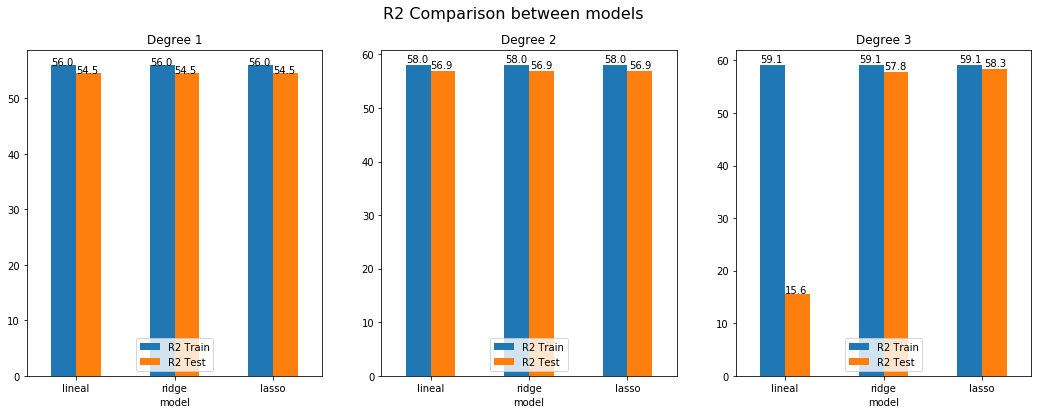

In [110]:
fig = plt.figure(figsize=(18,6))
plt.suptitle("R2 Comparison between models",fontsize=16)
ax1 = fig.add_subplot(131)
results_df.loc[results_df['degree']==1].plot(x='model',y=['R2 Train','R2 Test'],kind='bar',rot=0,title='Degree 1',ax=ax1)
ax1.legend(loc='lower center')
# plt.ylim([0.5,0.58])
for p in ax1.patches:
    ax1.annotate(str(round(p.get_height(),4)), (p.get_x() * 1.001, p.get_height() * 1.001))
    
ax2 = fig.add_subplot(132)
results_df.loc[results_df['degree']==2].plot(x='model',y=['R2 Train','R2 Test'],kind='bar',rot=0,title='Degree 2',ax=ax2)
ax2.legend(loc='lower center')
for p in ax2.patches:
    ax2.annotate(str(round(p.get_height(),4)), (p.get_x() * 1.01, p.get_height() * 1.01))

ax3 = fig.add_subplot(133)
results_df.loc[results_df['degree']==3].plot(x='model',y=['R2 Train','R2 Test'],kind='bar',rot=0,title='Degree 3',ax=ax3)
ax3.legend(loc='lower center')
for p in ax3.patches:
    ax3.annotate(str(round(p.get_height(),4)), (p.get_x() * 1.01, p.get_height() * 1.01))

#plt.savefig('Modelo GBA Scores v1.png')

Si bien el mejor modelo es Regresión Lasso con polinomiales de orden 3, por los problemas de convergencia vistos vamos a seleccionar el modelo con regularizacion Ridge

# 10. Elección del modelo

Luego de lo anterior visto, se opta por un modelo de Regresión Ridge, con features polinomiales de orden 3. Si bien el de Lasso tiene un score un poco mejor, el de Ridge converge sin problemas.

In [156]:
# alpha_lasso_model = model_lin_lasso_pol3.alpha_
# gba_model = Lasso(alpha=alpha_lasso_model)
#instanciamos los hiperparámetros  

alpha_ridge_model = model_lin_ridge_pol3.alpha_
gba_model = Ridge(alpha=alpha_ridge_model)

# 11 División del dataset en Train y Test para portfolio de 100 propiedades.

In [112]:
data_train, data_test = train_test_split(data_gba,test_size=100,shuffle=True)

In [113]:
data_train_final = data_train.copy()
data_test_final = data_test.copy()

In [114]:
#data_train_final.drop(columns='cub_desc',inplace=True)

In [115]:
data_train_final.shape,data_test_final.shape

((20176, 52), (100, 52))

In [116]:
data_train_final.columns

Index(['tipo_propiedad', 'Provincia', 'Localidad', 'cochera', 'gimnasio',
       'piscina', 'SUM', 'laundry', 'balcon', 'patio', 'parrilla', 'floor',
       'rooms', 'sup_cub', 'sup_descub', 'sup_total', 'price_usd_per_m2',
       'tipo_propiedad_apartment', 'tipo_propiedad_house',
       'tipo_propiedad_store', 'Localidad_Avellaneda', 'Localidad_Berazategui',
       'Localidad_Cañuelas', 'Localidad_Escobar',
       'Localidad_Esteban Echeverría', 'Localidad_Ezeiza',
       'Localidad_Florencio Varela', 'Localidad_General Rodríguez',
       'Localidad_General San Martín', 'Localidad_Hurlingham',
       'Localidad_Ituzaingó', 'Localidad_José C Paz', 'Localidad_La Matanza',
       'Localidad_La Plata', 'Localidad_Lanús', 'Localidad_Lomas de Zamora',
       'Localidad_Malvinas Argentinas', 'Localidad_Marcos Paz',
       'Localidad_Merlo', 'Localidad_Moreno', 'Localidad_Morón',
       'Localidad_Pilar', 'Localidad_Presidente Perón', 'Localidad_Quilmes',
       'Localidad_San Fernando', 'Lo

## 11.1 Imputación del número de piso ('floor')

In [117]:
data_train_final['floor'].isna().sum()

4922

In [118]:
data_test_final['floor'].isna().sum()

22

Solo se imputan datos en propiedades de tipo 'apartment'.

In [119]:
floor_median_localidad = data_train_final.loc[data_train_final['tipo_propiedad']=='apartment',['floor','Localidad']].groupby('Localidad').agg(np.median)
floor_median_localidad['floor'].fillna(value=floor_median_localidad['floor'].mean(),inplace=True)
floor_median_localidad.head(10)

,floor
Localidad,
Almirante Brown,3.5
Avellaneda,5.0
Escobar,1.0
Florencio Varela,3.0
General Rodríguez,2.0
General San Martín,2.0
Ituzaingó,2.0
La Matanza,2.0
La Plata,4.0


In [120]:
for localidad,floor_med in floor_median_localidad['floor'].to_dict().items():
    #imputo en el train set con los valores calculados
    data_train_final.loc[(data_train_final['floor'].isna())&(data_train_final['Localidad']==localidad),'floor']=floor_med
    #tambien imputo en el test set con los valores del train set.
    data_test_final.loc[(data_test_final['floor'].isna())&(data_test_final['Localidad']==localidad),'floor']=floor_med

In [121]:
print("Datos faltantes de floor en train set: {}".format(data_train_final['floor'].isna().sum()))
print("Datos faltantes de floor en test set: {}".format(data_test_final['floor'].isna().sum()))

Datos faltantes de floor en train set: 0
Datos faltantes de floor en test set: 0


In [122]:
data_train_final.loc[data_train_final['floor'].isna(),'Localidad'].value_counts()

Series([], Name: Localidad, dtype: int64)

In [123]:
data_train_final.loc[data_train_final['floor'].isna(),['Localidad','Provincia','floor']]

,Localidad,Provincia,floor


In [124]:
data_test_final.loc[data_test_final['floor'].isna(),'Localidad'].value_counts()

Series([], Name: Localidad, dtype: int64)

Los que quedan, se imputan por la media por provincia:

In [125]:
floor_median_prov = data_train_final.loc[data_train_final['tipo_propiedad']=='apartment',['floor','Provincia']].groupby('Provincia').agg(np.median)
floor_median_prov['floor'].fillna(value=floor_median_prov['floor'].mean(),inplace=True)
floor_median_prov.head(10)

,floor
Provincia,
Bs.As. G.B.A. Zona Norte,3.0
Bs.As. G.B.A. Zona Oeste,3.0
Bs.As. G.B.A. Zona Sur,3.0


In [126]:
for prov,floor_med in floor_median_prov['floor'].to_dict().items():
    #imputo en el train set con los valores calculados
    data_train_final.loc[(((data_train_final['tipo_propiedad']=='apartment')|(data_train_final['tipo_propiedad']=='store'))&(data_train_final['floor'].isna())&(data_train_final['Provincia']==prov)),'floor']=floor_med
    #tambien imputo en el test set con los valores del train set.
    data_test_final.loc[(((data_test_final['tipo_propiedad']=='apartment')|(data_test_final['tipo_propiedad']=='store'))&(data_test_final['floor'].isna())&(data_test_final['Provincia']==prov)),'floor']=floor_med

In [127]:
print("Datos faltantes de floor en train set: {}".format(data_train_final['floor'].isna().sum()))
print("Datos faltantes de floor en test set: {}".format(data_test_final['floor'].isna().sum()))

Datos faltantes de floor en train set: 0
Datos faltantes de floor en test set: 0


In [128]:
data_train_final.loc[data_train_final['floor'].isna(),'Localidad'].value_counts()

Series([], Name: Localidad, dtype: int64)

In [129]:
data_train_final.loc[data_train_final['floor'].isna(),['Provincia','Localidad','floor']]

,Provincia,Localidad,floor


In [130]:
data_test_final.loc[data_test_final['floor'].isna(),'Localidad'].value_counts()

Series([], Name: Localidad, dtype: int64)

## 11.2 Imputación de Superficies

Columna temporal de const_index.

In [131]:
data_train_final['const_index']=data_train_final['sup_cub']/data_train_final['sup_total']
#data_test['const_index']=0
data_train_final.head(5)

,tipo_propiedad,Provincia,Localidad,cochera,gimnasio,piscina,SUM,laundry,balcon,patio,...,Localidad_Quilmes,Localidad_San Fernando,Localidad_San Isidro,Localidad_San Miguel,Localidad_San Vicente,Localidad_Tigre,Localidad_Tres de Febrero,Localidad_Vicente López,sup_por_room,const_index
8435,house,Bs.As. G.B.A. Zona Norte,Tigre,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,25.25,0.909910
13390,house,Bs.As. G.B.A. Zona Sur,Ezeiza,1.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.00,0.342857
2746,apartment,Bs.As. G.B.A. Zona Oeste,Tres de Febrero,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,25.00,0.909091
18388,PH,Bs.As. G.B.A. Zona Norte,San Isidro,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,15.50,1.000000
9807,apartment,Bs.As. G.B.A. Zona Sur,Avellaneda,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


In [132]:
const_median_loc = data_train_final[['const_index','Localidad']].groupby('Localidad').median()
const_median_loc['const_index'].fillna(value=const_median_loc['const_index'].mean(),inplace=True)
const_median_loc.head(10)

,const_index
Localidad,
Almirante Brown,0.855112
Avellaneda,0.914286
Berazategui,0.885971
Cañuelas,0.775148
Escobar,0.883721
Esteban Echeverría,0.816667
Ezeiza,0.830000
Florencio Varela,0.883721
General Rodríguez,0.815518


Imputación del índice de construcción:

In [133]:
data_train_final[['sup_cub','sup_total','sup_descub']].isna().sum()

sup_cub       2405
sup_total     1666
sup_descub    4071
dtype: int64

In [134]:
for localidad,const_med in const_median_loc['const_index'].to_dict().items():
    data_train_final.loc[(data_train_final['const_index'].isna())&(data_train_final['Localidad']==localidad),'const_index']=const_med
    data_test_final.loc[(data_test_final['Localidad']==localidad),'const_index']=const_med

Completar los datos faltantes de Superficie Cubierta y Superficie Total con el índice de construcción calculado, en el set de entrenamiento.

In [135]:
data_train_final['sup_cub'].fillna(data_train_final['const_index']*data_train_final['sup_total'],inplace=True)
data_train_final['sup_total'].fillna(data_train_final['sup_cub']/data_train_final['const_index'],inplace=True)
data_train_final['sup_descub'].fillna((data_train_final['sup_total']-data_train_final['sup_cub']),inplace=True)

Completar los datos faltantes de Superficie Cubierta y Superficie Total con el índice de construcción calculado, en el set de testeo.

In [136]:
data_test_final['sup_cub'].fillna(data_test_final['const_index']*data_test_final['sup_total'],inplace=True)
data_test_final['sup_total'].fillna(data_test_final['sup_cub']/data_test_final['const_index'],inplace=True)
data_test_final['sup_descub'].fillna((data_test_final['sup_total']-data_test_final['sup_cub']),inplace=True)

In [137]:
#data_train_final['cub_desc'].fillnadata_train_final['sup_cub']*data_train_final['sup_descub']
data_train_final['sup_por_room'].fillna(data_train_final['sup_cub']/data_train_final['rooms'],inplace=True)

In [138]:
data_test_final['sup_por_room'].fillna(data_test_final['sup_cub']/data_test_final['rooms'],inplace=True)

In [139]:
data_train_final[['sup_cub','sup_total','sup_descub','sup_por_room']].isna().sum()

sup_cub         0
sup_total       0
sup_descub      0
sup_por_room    0
dtype: int64

In [140]:
data_test_final[['sup_cub','sup_total','sup_descub','sup_por_room']].isna().sum()

sup_cub         0
sup_total       0
sup_descub      0
sup_por_room    0
dtype: int64

In [141]:
data_train_final.columns

Index(['tipo_propiedad', 'Provincia', 'Localidad', 'cochera', 'gimnasio',
       'piscina', 'SUM', 'laundry', 'balcon', 'patio', 'parrilla', 'floor',
       'rooms', 'sup_cub', 'sup_descub', 'sup_total', 'price_usd_per_m2',
       'tipo_propiedad_apartment', 'tipo_propiedad_house',
       'tipo_propiedad_store', 'Localidad_Avellaneda', 'Localidad_Berazategui',
       'Localidad_Cañuelas', 'Localidad_Escobar',
       'Localidad_Esteban Echeverría', 'Localidad_Ezeiza',
       'Localidad_Florencio Varela', 'Localidad_General Rodríguez',
       'Localidad_General San Martín', 'Localidad_Hurlingham',
       'Localidad_Ituzaingó', 'Localidad_José C Paz', 'Localidad_La Matanza',
       'Localidad_La Plata', 'Localidad_Lanús', 'Localidad_Lomas de Zamora',
       'Localidad_Malvinas Argentinas', 'Localidad_Marcos Paz',
       'Localidad_Merlo', 'Localidad_Moreno', 'Localidad_Morón',
       'Localidad_Pilar', 'Localidad_Presidente Perón', 'Localidad_Quilmes',
       'Localidad_San Fernando', 'Lo

In [142]:
data_test_final.columns

Index(['tipo_propiedad', 'Provincia', 'Localidad', 'cochera', 'gimnasio',
       'piscina', 'SUM', 'laundry', 'balcon', 'patio', 'parrilla', 'floor',
       'rooms', 'sup_cub', 'sup_descub', 'sup_total', 'price_usd_per_m2',
       'tipo_propiedad_apartment', 'tipo_propiedad_house',
       'tipo_propiedad_store', 'Localidad_Avellaneda', 'Localidad_Berazategui',
       'Localidad_Cañuelas', 'Localidad_Escobar',
       'Localidad_Esteban Echeverría', 'Localidad_Ezeiza',
       'Localidad_Florencio Varela', 'Localidad_General Rodríguez',
       'Localidad_General San Martín', 'Localidad_Hurlingham',
       'Localidad_Ituzaingó', 'Localidad_José C Paz', 'Localidad_La Matanza',
       'Localidad_La Plata', 'Localidad_Lanús', 'Localidad_Lomas de Zamora',
       'Localidad_Malvinas Argentinas', 'Localidad_Marcos Paz',
       'Localidad_Merlo', 'Localidad_Moreno', 'Localidad_Morón',
       'Localidad_Pilar', 'Localidad_Presidente Perón', 'Localidad_Quilmes',
       'Localidad_San Fernando', 'Lo

In [143]:
poly_vars = ['floor','rooms','sup_cub','sup_descub','sup_por_room']
y_column = ['price_usd_per_m2']
poly_drop = ['tipo_propiedad', 'Localidad','Provincia','sup_total','const_index']
data_train3 = data_train_final.drop(columns=poly_drop).copy()
y_train = data_train_final[y_column[0]]
data_test3 = data_test_final.drop(columns=poly_drop).copy()
y_test = data_test_final[y_column[0]]

X_train_pol3,X_test_pol3 = get_poly_X(poly_vars = poly_vars, y_var = y_column, df_train = data_train3, df_test = data_test3,degree=3)
print(X_train_pol3.shape,X_test_pol3.shape)

Xs_train_pol3 = stdscalerX.fit_transform(X_train_pol3)
ys_train_pol3 = y_train

Xs_test_pol3 = stdscalerX.transform(X_test_pol3)
ys_test_pol3 = y_test

(20176, 97) (100, 97)


In [144]:
data_test3.shape

(100, 48)

In [145]:
#Ridge Regression Model
# alpha_lasso_model = model_lin_lasso_pol3.alpha_
# gba_model = Lasso(alpha=alpha_lasso_model,max_iter=100000,selection='random')
alpha_ridge_model = model_lin_ridge_pol3.alpha_
gba_model = Ridge(alpha=alpha_ridge_model)
gba_model = gba_model.fit(Xs_train_pol3, ys_train_pol3)

CrossValidation Score:

In [146]:
for _ in range(10):
    kf3 = KFold(n_splits=5, shuffle=True)
    print(cross_val_score(gba_model, Xs_train_pol3, ys_train_pol3, cv=kf3))  

[0.533 0.594 0.59  0.578 0.578]
[0.093 0.56  0.598 0.584 0.602]
[0.59  0.584 0.43  0.583 0.586]
[ 0.587 -0.473  0.606  0.585  0.567]
[0.338 0.594 0.568 0.603 0.577]
[0.568 0.599 0.584 0.584 0.574]
[0.57  0.56  0.594 0.589 0.592]
[0.58  0.601 0.587 0.582 0.553]
[0.599 0.588 0.575 0.589 0.579]
[0.573 0.552 0.584 0.602 0.579]


In [147]:
y_pred_tr = gba_model.predict(Xs_train_pol3)
y_pred_ts = gba_model.predict(Xs_test_pol3)

print("----------------------------")
print("Train set")
print("----------------------------")
print_metrics(y_train,y_pred_tr)
print("----------------------------")
print("Test set")
print("----------------------------")
print_metrics(y_test,y_pred_ts)


----------------------------
Train set
----------------------------
MAE: 345.026065
MSE: 221712.008907
RMSE: 470.863047
R2: 0.5921
----------------------------
Test set
----------------------------
MAE: 346.43935
MSE: 227967.225036
RMSE: 477.459134
R2: 0.5284


In [148]:
portfolio = pd.DataFrame(y_test).rename(columns={'price_usd_per_m2':'Real_Price'})
portfolio['Model_Prediction']=y_pred_ts
portfolio['diff'] = portfolio['Model_Prediction']-portfolio['Real_Price']
portfolio['Sobre/Sub'] = portfolio['diff'].apply(lambda x: 'Sobrevaluado' if x>0 else 'Subvaluado')
portfolio['abs_diff']=portfolio['diff'].abs()
portfolio.head(10)

,Real_Price,Model_Prediction,diff,Sobre/Sub,abs_diff
18807,1555.555556,1268.690768,-286.864787,Subvaluado,286.864787
11261,2578.947368,1844.650697,-734.296672,Subvaluado,734.296672
6044,1111.689423,1324.973923,213.284500,Sobrevaluado,213.284500
6798,1770.833333,1869.646972,98.813638,Sobrevaluado,98.813638
1921,2241.379310,1785.920067,-455.459243,Subvaluado,455.459243
5629,546.448087,1494.809046,948.360959,Sobrevaluado,948.360959
14411,1068.376068,954.087863,-114.288205,Subvaluado,114.288205
12103,707.299270,875.845802,168.546532,Sobrevaluado,168.546532
8519,909.090909,780.464587,-128.626322,Subvaluado,128.626322
17346,1038.461538,907.308063,-131.153476,Subvaluado,131.153476


In [149]:
portfolio.describe()

,Real_Price,Model_Prediction,diff,abs_diff
count,100.000000,100.000000,100.000000,100.000000
mean,1333.906553,1358.698919,24.792366,346.439350
std,698.795053,523.188881,479.217126,330.208079
min,141.666667,322.422586,-1473.013227,13.094031
25%,895.958519,1024.576888,-217.650676,134.631348
50%,1260.919540,1307.712854,73.053254,245.065730
75%,1733.103448,1751.973082,256.468362,441.979316
max,3705.882353,2542.241460,1955.420167,1955.420167


In [150]:
sobrevaluados = portfolio.loc[portfolio['Sobre/Sub']=='Sobrevaluado','Sobre/Sub'].count()
subvaluados = portfolio.loc[portfolio['Sobre/Sub']=='Subvaluado','Sobre/Sub'].count()
sobrevaluados,subvaluados

(54, 46)

In [151]:
#portfolio.plot(kind='scatter',x='Real_Price',y='Model_Prediction',figsize=(8,6))

In [152]:
#plt.figure(figsize=(8,6))
#sns.regplot(x="Real_Price", y="Model_Prediction", data=portfolio)

In [153]:
#plt.figure(figsize=(8,6))
#plt.scatter(x=ys_test_pol3, y =y_pred_ts)
#plt.title('Valores predichos Vs. Valores Reales (Ridge)', fontsize=16)
#plt.ylabel('Valores Predichos')
#plt.xlabel('Valores Reales')

Text(0, 0.5, 'Real Value - Predicted Value')

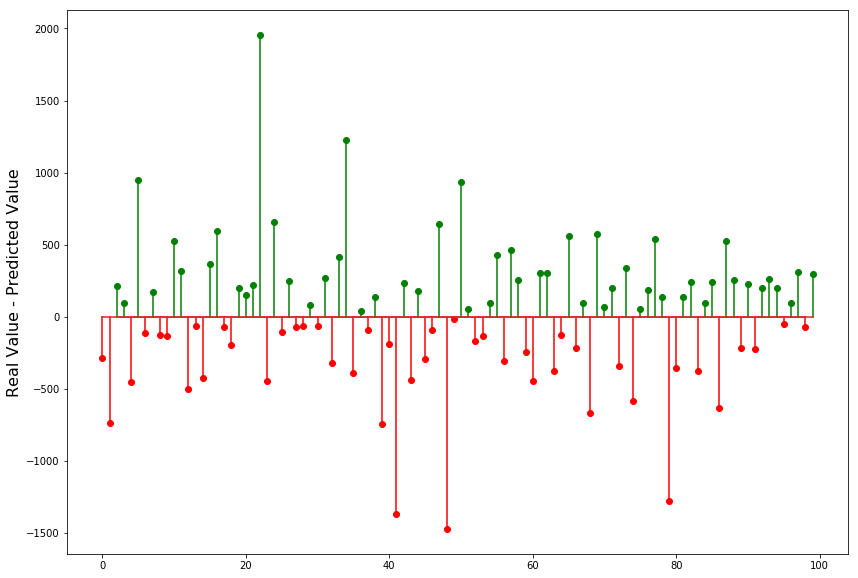

In [154]:
port_df = portfolio.reset_index().drop(columns='index').reset_index()
port_plot_df = port_df.sample(100)
#display(port_plot_df)
#port_plot_df.plot(kind='scatter',x='index',y='diff',figsize=(8,6))
plt.figure(figsize=(14,10))
sobreval = port_plot_df.loc[port_plot_df['Sobre/Sub']=='Sobrevaluado']
subval = port_plot_df.loc[port_plot_df['Sobre/Sub']=='Subvaluado']
#plt.stem(port_plot_df['index'],port_plot_df['diff'])
plt.stem(subval['index'],subval['diff'],linefmt='red',markerfmt='or')
plt.stem(sobreval['index'],sobreval['diff'],linefmt='green',markerfmt='og')
plt.ylabel('Real Value - Predicted Value',fontsize=16)
#plt.savefig('../Images/GBA Portfolio.png')